# Part 1: DBSCAN — Research

## Contents

[PCA and Pruning Away at Features](#pca-and-pruning-away-at-features)\
&emsp;[Data Visualisation](#data-visualisation)\
&emsp;[Attempts at Improving the Spread of the Samples Across the Clusters](#attempts-at-improving-the-spread-of-the-samples-across-the-clusters)\
&emsp;&emsp;[With a Minimum TF-IDF Threshold](#with-a-minimum-tf-idf-threshold)\
&emsp;&emsp;&emsp;[Where Do Outliers Go When Their Numbers go Down?](#where-do-outliers-go-when-their-numbers-go-down)\
&emsp;&emsp;[With a Minimum Feature Occurence Threshold]()\
&emsp;&emsp;&emsp;[With a Minimum Cluster Size of 6 (the winning combination!)](#with-a-minimum-cluster-size-of-6-the-winning-combination)\
[Results and Word Clouds](#results)



In [ ]:
import spacy, wordcloud
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
data_df = pd.read_csv("./Data/sample-data.csv")

data_df.head()

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...

In [ ]:
df = data_df.copy()
df["clean_docs"] = df["description"].str.replace(r"<[^>]*>", " ", regex=True)\
                                    .str.replace(r"[^a-zA-Z0-9']+", " ", regex=True)\
                                    .apply(lambda desc: nlp(desc.lower()))\
                                    .apply(lambda doc: [token.lemma_ for token in doc if token.text not in STOP_WORDS])\
                                    .apply(lambda ls: " ".join(ls))

In [ ]:
# I am not using a max or min document frequency for terms because I want to decide which cols to keep after the n-grams are made
vectoriser = TfidfVectorizer(stop_words="english", ngram_range=(1, 4))
X = vectoriser.fit_transform(df["clean_docs"])
len(vectoriser.vocabulary_)

80511

In [ ]:
dense = X.todense()
tfidf_df = pd.DataFrame(dense, 
                        columns=vectoriser.vocabulary_, 
                        index=[f"doc_{x}" for x in range(1, dense.shape[0]+1)])
tfidf_df.head()

active  classic  boxer  reason  cult  favorite  cool  especially  \
doc_1     0.0      0.0    0.0     0.0   0.0       0.0   0.0         0.0   
doc_2     0.0      0.0    0.0     0.0   0.0       0.0   0.0         0.0   
doc_3     0.0      0.0    0.0     0.0   0.0       0.0   0.0         0.0   
doc_4     0.0      0.0    0.0     0.0   0.0       0.0   0.0         0.0   
doc_5     0.0      0.0    0.0     0.0   0.0       0.0   0.0         0.0   

       sticky  situation  ...  flat zip fly button  entry drop pocket welt  \
doc_1     0.0        0.0  ...                  0.0                     0.0   
doc_2     0.0        0.0  ...                  0.0                     0.0   
doc_3     0.0        0.0  ...                  0.0                     0.0   
doc_4     0.0        0.0  ...                  0.0                     0.0   
doc_5     0.0        0.0  ...                  0.0                     0.0   

       drop pocket welt pocket  welt pocket inseam update  \
doc_1                      0.0                        0.0   
doc_2                      0.0                        0.0   
doc_3                      0.0                        0.0   
doc_4                      0.0                        0.0   
doc_5                      0.0                        0.0   

       pocket inseam update fit  inseam update fit fabric  \
doc_1                       0.0                       0.0   
doc_2                       0.0                       0.0   
doc_3                       0.0                       0.0   
doc_4                       0.0                       0.0   
doc_5                       0.0                       0.0   

       update fit fabric oz  recycle program weight 282  \
doc_1                   0.0                         0.0   
doc_2                   0.0                         0.0   
doc_3                   0.0                         0.0   
doc_4                   0.0                         0.0   
doc_5                   0.0                         0.0   

       program weight 282 oz  weight 282 oz thailand  
doc_1                    0.0                     0.0  
doc_2                    0.0                     0.0  
doc_3                    0.0                     0.0  
doc_4                    0.0                     0.0  
doc_5                    0.0                     0.0  

[5 rows x 80511 columns]

In [ ]:
cols_more_than_one = [term for term in vectoriser.vocabulary_
                      if len(tfidf_df[tfidf_df[term] != 0.0]) > 1] # I checked that no elements were negative, but I used `!=` just to be sure.
denser_df = tfidf_df[cols_more_than_one]
denser_df.head()

active  classic  boxer  reason  lightweight  travel  pack  expose  \
doc_1     0.0      0.0    0.0     0.0     0.000000     0.0   0.0     0.0   
doc_2     0.0      0.0    0.0     0.0     0.000000     0.0   0.0     0.0   
doc_3     0.0      0.0    0.0     0.0     0.000000     0.0   0.0     0.0   
doc_4     0.0      0.0    0.0     0.0     0.000000     0.0   0.0     0.0   
doc_5     0.0      0.0    0.0     0.0     0.019869     0.0   0.0     0.0   

       softness  traditional  ...  flat zip fly button  \
doc_1       0.0          0.0  ...                  0.0   
doc_2       0.0          0.0  ...                  0.0   
doc_3       0.0          0.0  ...                  0.0   
doc_4       0.0          0.0  ...                  0.0   
doc_5       0.0          0.0  ...                  0.0   

       entry drop pocket welt  drop pocket welt pocket  \
doc_1                     0.0                      0.0   
doc_2                     0.0                      0.0   
doc_3                     0.0                      0.0   
doc_4                     0.0                      0.0   
doc_5                     0.0                      0.0   

       welt pocket inseam update  pocket inseam update fit  \
doc_1                        0.0                       0.0   
doc_2                        0.0                       0.0   
doc_3                        0.0                       0.0   
doc_4                        0.0                       0.0   
doc_5                        0.0                       0.0   

       inseam update fit fabric  update fit fabric oz  \
doc_1                       0.0                   0.0   
doc_2                       0.0                   0.0   
doc_3                       0.0                   0.0   
doc_4                       0.0                   0.0   
doc_5                       0.0                   0.0   

       recycle program weight 282  program weight 282 oz  \
doc_1                         0.0                    0.0   
doc_2                         0.0                    0.0   
doc_3                         0.0                    0.0   
doc_4                         0.0                    0.0   
doc_5                         0.0                    0.0   

       weight 282 oz thailand  
doc_1                     0.0  
doc_2                     0.0  
doc_3                     0.0  
doc_4                     0.0  
doc_5                     0.0  

[5 rows x 23757 columns]

## PCA and Pruning Away at Features

### Data Visualisation
For DBSCAN, it seems that it would be advantageous to have more clear-cut categories, so let's remove some features that have a particularly low average TF-IDF. \
Let's also see if PCA can yield something interesting that we can plot in 3D.

I will arbitrarily pick the minimum mean TF-IDF that gave us 5131 features in the test conducted earlier: 0.059

In [ ]:
eligible_features = [term for term in denser_df.columns
                    if (denser_df[denser_df[term] > 0][term].mean() > 0.059)]
for_dbscan_df = denser_df[eligible_features]
for_dbscan_df.shape

(500, 5131)

In [ ]:
# Why I am doing a PCA first: https://stats.stackexchange.com/a/364908

pca = PCA(n_components=3, random_state=444719)

for_dbscan_PC = pca.fit_transform(for_dbscan_df) # "PC" is what the variable is called in the lessons

for_dbscan_PC[:5]

array([[-0.03551301, -0.02885299, -0.03004389],
       [-0.02648039, -0.01758852, -0.01426449],
       [-0.02580886, -0.01713162, -0.0136268 ],
       [-0.02618007, -0.01398485, -0.01243765],
       [-0.0262224 , -0.01768224, -0.01403437]])

In [ ]:
db = DBSCAN(eps=0.01, min_samples=2, metric="cosine", algorithm="auto")
db.fit(for_dbscan_PC)

DBSCAN(eps=0.01, metric='cosine', min_samples=2)

In [ ]:
for label in np.unique(db.labels_):
    print(label, ":", len(for_dbscan_PC[db.labels_ == label]))

-1 : 7
0 : 318
1 : 20
2 : 54
3 : 79
4 : 6
5 : 2
6 : 6
7 : 2
8 : 2
9 : 4


In [ ]:
db.components_

array([[-0.03551301, -0.02885299, -0.03004389],
       [-0.02648039, -0.01758852, -0.01426449],
       [-0.02580886, -0.01713162, -0.0136268 ],
       ...,
       [-0.03689125, -0.02224889, -0.02114081],
       [-0.00100227, -0.02704442, -0.00205988],
       [ 0.00159732, -0.02286714, -0.00123781]], shape=(498, 3))

In [ ]:
fig = px.scatter_3d(x=for_dbscan_PC[:, 0], y=for_dbscan_PC[:, 1], z=for_dbscan_PC[:, 2], color=db.labels_.astype(str), color_discrete_sequence=px.colors.qualitative.G10)
fig.update_traces(marker_size=4)

fig.show()

It works, but there are a few clusters that are clumped up in the middle. Let's see if we can fix that:

In [ ]:
db_2 = DBSCAN(eps=0.82, min_samples=2, metric="cosine", algorithm="auto")
db_2.fit(for_dbscan_df) # non-PCA'ed data

DBSCAN(eps=0.82, metric='cosine', min_samples=2)

In [ ]:
for label in np.unique(db_2.labels_):
    print(label, ":", len(for_dbscan_df[db_2.labels_ == label]))

-1 : 3
0 : 436
1 : 2
2 : 2
3 : 4
4 : 2
5 : 3
6 : 9
7 : 2
8 : 4
9 : 5
10 : 2
11 : 3
12 : 4
13 : 3
14 : 4
15 : 3
16 : 2
17 : 5
18 : 2


In [ ]:
fig = px.scatter_3d(x=for_dbscan_PC[:, 0], y=for_dbscan_PC[:, 1], z=for_dbscan_PC[:, 2], color=db_2.labels_.astype(str))
fig.update_traces(marker_size=4)

fig.show()

Hard to read and seemingly not balanced enough to be useful. We don't need to visualise the clusters, so let's try a higher number of principal components and skip the visualisation. \
I'll include all of `denser_df` (with 1-4-grams, minus features that occurred only once).

## Attempts at Improving the Spread of the Samples Across the Clusters

### With a Minimum TF-IDF Threshold

In [ ]:
# Why I am doing a PCA first: https://stats.stackexchange.com/a/364908

pca = PCA(n_components=100, random_state=444719)

for_dbscan_PC = pca.fit_transform(denser_df) # "PC" is what the variable is called in the lessons

In [ ]:
db = DBSCAN(eps=0.58, min_samples=4, metric="cosine", algorithm="brute") # switched to "brute" from "auto" because it turns out that it's the only one compatible with the "cosine" metric.
db.fit(for_dbscan_PC)

for label in np.unique(db.labels_):
    print(label, ":", len(for_dbscan_PC[db.labels_ == label]))

-1 : 36
0 : 396
1 : 10
2 : 4
3 : 8
4 : 9
5 : 15
6 : 4
7 : 6
8 : 4
9 : 4
10 : 4


In [ ]:
best_eps, best_min_samples = -1.0, -1
best_outliers, best_std = np.inf, np.inf

for eps in tqdm([i/10_000 for i in range(1, 10000)]):
    for min_samples in range(1, 20):
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm="brute")
        db.fit(for_dbscan_PC)
        labels = db.labels_
        unique_labels = np.unique(labels)
        if (10 <= len(unique_labels) <= 20):
            labels_spread = [len(for_dbscan_PC[labels == label]) for label in unique_labels
                             if label != -1]
            current_std = np.std(labels_spread)
            current_outliers = len(for_dbscan_PC[labels == -1])
            if ((current_outliers <= best_outliers + 10) and (current_std < best_std))\
                or ((current_outliers < best_outliers) and (current_std <= best_std + 10)):
                best_outliers = current_outliers
                best_std = current_std
                best_eps = eps
                best_min_samples = min_samples
                print(f"Best results so far:\neps: {best_eps}\nmin_samples: {best_min_samples}\nOutliers: {best_outliers}\nLabels spread:{labels_spread}\n\n")

In most configurations I've tried, there always is the one cluster that has a lot of members (either the outliers or cluster 0). I suspect that this is related to the central clump we see in the visualisations.

The output of the cell above is huge, so I removed it for the deliverable. \
Here are my best results so far when trying to keep the cluster sizes balanced:
```md
eps: 0.4478
min_samples: 5
Outliers: 100
Labels spread:[22, 36, 16, 162, 10, 10, 6, 53, 8, 6, 30, 9, 15, 5, 7, 5]

eps: 0.491
min_samples: 4
Outliers: 52
Labels spread:[236, 42, 16, 10, 10, 53, 4, 7, 8, 6, 9, 15, 4, 4, 7, 4, 4, 5, 4]
```
I've also managed to have very few or no outliers, but then the clusters are either huge or tiny.

Let's see if there are fewer outliers if I remove features again, even more drastically, and reduce the number of PCA components.

3891 features is close to the 3825 we had right after the pre-processing phase:

In [ ]:
eligible_features = [term for term in denser_df.columns
                    if (denser_df[denser_df[term] > 0][term].mean() > 0.063)]
for_dbscan_df = denser_df[eligible_features]
for_dbscan_df.shape

(500, 3891)

In [ ]:
# Why I am doing a PCA first: https://stats.stackexchange.com/a/364908

pca = PCA(n_components=10, random_state=444719)

for_dbscan_PC = pca.fit_transform(for_dbscan_df) # "PC" is what the variable is called in the lessons

In [ ]:
best_eps, best_min_samples = -1.0, -1
best_outliers, best_std = np.inf, np.inf
best_labels_spread = []

for index, eps in tqdm(enumerate([i/100_000 for i in range(1, 100_000)])):
    for min_samples in range(1, 20):
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm="brute")
        db.fit(for_dbscan_PC)
        labels = db.labels_
        unique_labels = np.unique(labels)
        if (10 <= len(unique_labels) <= 20): # The instructions ask for 10 to 20 clusters
            labels_spread = [len(for_dbscan_PC[labels == label]) for label in unique_labels
                             if label != -1]
            current_std = np.std(labels_spread)
            current_outliers = len(for_dbscan_PC[labels == -1])
            if (((current_outliers <= best_outliers + 10) and (current_std < best_std))\
                or ((current_outliers < best_outliers) and (current_std <= best_std + 10)))\
                and (1 not in labels_spread):
                best_labels_spread = labels_spread
                best_outliers = current_outliers
                best_std = current_std
                best_eps = eps
                best_min_samples = min_samples
    if index % 1234 == 0: # Made the size of the output more manageable so I can leave it for examinators to see
        print(f"Best results so far:\neps: {best_eps}\nmin_samples: {best_min_samples}\nOutliers: {best_outliers}\nLabels spread:{best_labels_spread}\n\n")

3it [00:00,  9.90it/s]

Best results so far:
eps: -1.0
min_samples: -1
Outliers: inf
Labels spread:[]




1236it [02:04,  9.85it/s]

Best results so far:
eps: 0.01222
min_samples: 4
Outliers: 96
Labels spread:[204, 8, 9, 5, 51, 4, 19, 31, 6, 7, 7, 21, 4, 6, 14, 4, 4]




2470it [04:13,  9.60it/s]

Best results so far:
eps: 0.02301
min_samples: 3
Outliers: 48
Labels spread:[244, 9, 6, 10, 52, 20, 31, 3, 7, 4, 6, 7, 21, 6, 16, 3, 4, 3]




3704it [06:23,  9.76it/s]

Best results so far:
eps: 0.03423
min_samples: 2
Outliers: 18
Labels spread:[292, 13, 10, 52, 20, 31, 7, 2, 6, 7, 21, 6, 3, 2, 2, 2, 2, 2, 2]




4938it [08:35,  9.31it/s]

Best results so far:
eps: 0.04337
min_samples: 2
Outliers: 8
Labels spread:[300, 13, 2, 10, 53, 20, 31, 7, 2, 6, 7, 21, 6, 4, 2, 2, 2, 2, 2]




6172it [10:47,  9.53it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




7406it [12:59,  9.54it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




8640it [15:12,  8.97it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




9874it [17:26,  9.19it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




11108it [19:40,  9.59it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




12342it [21:54,  9.05it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




13576it [24:08,  9.25it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




14810it [26:23,  9.29it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




16044it [28:39,  7.95it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




17278it [30:53,  9.47it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




18512it [33:10,  8.96it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




19746it [35:27,  8.50it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




20980it [37:44,  8.76it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




22214it [40:01,  9.34it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




23448it [42:18,  9.45it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




24682it [44:36,  8.76it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




25916it [46:53,  8.94it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




27150it [49:11,  9.36it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




28384it [51:29,  9.11it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




29618it [53:47,  8.89it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




30852it [56:05,  8.95it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




32086it [58:25,  8.84it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




33320it [1:00:46,  8.81it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




34554it [1:03:04,  8.85it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




35788it [1:05:21,  9.33it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




37022it [1:07:40,  8.89it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




38256it [1:10:00,  8.87it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




39490it [1:12:20,  9.02it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




40724it [1:14:53,  8.26it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




41958it [1:17:20,  8.79it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




43192it [1:19:43,  9.14it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




44425it [1:22:10,  9.77it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




45660it [1:24:35,  9.39it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




46893it [1:26:55, 10.35it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




48128it [1:29:19,  8.61it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




49362it [1:31:54,  9.66it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




50596it [1:34:17,  9.01it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




51830it [1:36:36,  9.36it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




53064it [1:39:09,  9.84it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




54298it [1:41:25,  9.76it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




55532it [1:43:40,  9.22it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




56766it [1:45:56,  8.14it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




58000it [1:48:17,  7.72it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




59234it [1:50:45,  8.76it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




60468it [1:54:18,  5.07it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




61702it [1:58:26,  5.02it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




62936it [2:02:39,  5.01it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




64170it [2:06:47,  5.08it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




65403it [2:10:54,  4.75it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




66637it [2:15:13,  4.95it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




67871it [2:19:16,  5.04it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




69106it [2:23:26,  5.17it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




70340it [2:26:10,  9.52it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




71574it [2:28:21,  9.69it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




72808it [2:32:17,  5.02it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




74042it [2:36:38,  5.11it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




75276it [2:40:52,  5.10it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




76511it [2:44:20,  9.43it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




77744it [2:46:32,  8.83it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




78978it [2:48:46,  9.13it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




80212it [2:50:58,  9.55it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




81446it [2:53:12,  8.44it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




82680it [2:55:26,  9.56it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




83914it [2:57:38,  8.91it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




85148it [2:59:56,  9.09it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




86382it [3:02:18,  8.52it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




87616it [3:04:48,  8.50it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




88850it [3:07:16,  7.53it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




90084it [3:09:42,  7.29it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




91318it [3:12:12,  8.17it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




92552it [3:14:47,  9.32it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




93786it [3:17:11,  6.93it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




95020it [3:19:33,  5.15it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




96253it [3:23:23,  4.36it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




97487it [3:27:41,  4.79it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




98721it [3:31:55,  4.94it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




99955it [3:36:07,  5.07it/s]

Best results so far:
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]




99999it [3:36:16,  7.71it/s]


The output was still too long, but I would like you to be able to see it, so I simply collapsed it. Double-click on it to reveal its contents.\
The best result was:
```md
eps: 0.04987
min_samples: 2
Outliers: 7
Labels spread:[304, 13, 10, 53, 20, 31, 7, 6, 7, 22, 6, 4, 2, 2, 2, 2, 2]
```

#### Where Do Outliers Go When Their Numbers go Down?

I had results with 0 outliers in a test run that I removed because it had a mistake in the logging, and I want to get a glimpse of whether outliers went into the big cluster when they were no longer outliers:

In [ ]:
last_outliers_db = DBSCAN(eps=0.049869, min_samples=2, metric="cosine", algorithm="brute")
last_outliers_db.fit(for_dbscan_PC)
last_outliers_labels = last_outliers_db.labels_
last_outliers_unique_labels = np.unique(last_outliers_labels)
len(last_outliers_labels)

500

In [ ]:
last_outliers_index_list = np.where(last_outliers_labels == -1)[0]
last_outliers_index_list

array([ 44, 148, 157, 240, 289, 298, 384])

In [ ]:
no_outliers_db = DBSCAN(eps=0.075117, min_samples=1, metric="cosine", algorithm="brute")
no_outliers_db.fit(for_dbscan_PC)
no_outliers_labels = no_outliers_db.labels_
no_outliers_unique_labels = np.unique(no_outliers_labels)
len(no_outliers_labels)

500

In [ ]:
for label in no_outliers_unique_labels:
    print(label, ":", len(for_dbscan_PC[no_outliers_labels == label]))

0 : 339
1 : 13
2 : 53
3 : 31
4 : 1
5 : 7
6 : 6
7 : 7
8 : 22
9 : 6
10 : 1
11 : 1
12 : 2
13 : 1
14 : 2
15 : 2
16 : 2
17 : 1
18 : 2
19 : 1


In [ ]:
no_outliers_labels[last_outliers_index_list]

array([ 4, 10, 11, 13, 17,  0, 19])

Answer: Most of them each became their own cluster because the min_sample was too low! All my other tests will disallow clusters with only one member.

Let's tweak how rare a word is allowed to be instead:

### Improving the Spread of Samples Across the Clusters: With a Minimum Feature Occurence Threshold

In [ ]:
cols_more_than_four = [term for term in vectoriser.vocabulary_
                       if len(tfidf_df[tfidf_df[term] != 0.0]) > 4] # I checked that no elements were negative, but I used `!=` just to be sure.
denser_df = tfidf_df[cols_more_than_four]
denser_df.head()

lightweight  travel  pack  wicke  performance  inseam  elastic  \
doc_1     0.000000     0.0   0.0    0.0          0.0     0.0      0.0   
doc_2     0.000000     0.0   0.0    0.0          0.0     0.0      0.0   
doc_3     0.000000     0.0   0.0    0.0          0.0     0.0      0.0   
doc_4     0.000000     0.0   0.0    0.0          0.0     0.0      0.0   
doc_5     0.019869     0.0   0.0    0.0          0.0     0.0      0.0   

       comfort  weight   99  ...  arduous journey remain  program weight 282  \
doc_1      0.0     0.0  0.0  ...                     0.0                 0.0   
doc_2      0.0     0.0  0.0  ...                     0.0                 0.0   
doc_3      0.0     0.0  0.0  ...                     0.0                 0.0   
doc_4      0.0     0.0  0.0  ...                     0.0                 0.0   
doc_5      0.0     0.0  0.0  ...                     0.0                 0.0   

       weight 282 oz  cotton canvas withstand hard  soft touch feature wide  \
doc_1            0.0                           0.0                      0.0   
doc_2            0.0                           0.0                      0.0   
doc_3            0.0                           0.0                      0.0   
doc_4            0.0                           0.0                      0.0   
doc_5            0.0                           0.0                      0.0   

       touch feature wide entry  feature wide entry drop  \
doc_1                       0.0                      0.0   
doc_2                       0.0                      0.0   
doc_3                       0.0                      0.0   
doc_4                       0.0                      0.0   
doc_5                       0.0                      0.0   

       pocket inseam update fit  inseam update fit fabric  \
doc_1                       0.0                       0.0   
doc_2                       0.0                       0.0   
doc_3                       0.0                       0.0   
doc_4                       0.0                       0.0   
doc_5                       0.0                       0.0   

       update fit fabric oz  
doc_1                   0.0  
doc_2                   0.0  
doc_3                   0.0  
doc_4                   0.0  
doc_5                   0.0  

[5 rows x 5035 columns]

In [ ]:
# Why I am doing a PCA first: https://stats.stackexchange.com/a/364908

pca = PCA(n_components=100, random_state=444719)

for_dbscan_PC = pca.fit_transform(denser_df) # "PC" is what the variable is called in the lessons

In [ ]:
best_eps, best_min_samples = -1.0, -1
best_outliers, best_std = np.inf, np.inf
best_labels_spread = []
last_log = "hello"

for index, eps in tqdm(enumerate([i/10_000 for i in range(1, 10_000)])):
    for min_samples in range(2, 20):
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm="brute")
        db.fit(for_dbscan_PC)
        labels = db.labels_
        unique_labels = np.unique(labels)
        if (10 <= len(unique_labels) <= 20): # The instructions ask for 10 to 20 clusters
            labels_spread = [len(for_dbscan_PC[labels == label]) for label in unique_labels
                             if label != -1]
            current_std = np.std(labels_spread)
            current_outliers = len(for_dbscan_PC[labels == -1])
            if (((current_outliers <= best_outliers + 10) and (current_std < best_std))\
                or ((current_outliers < best_outliers) and (current_std <= best_std + 10)))\
                and (1 not in labels_spread):
                best_labels_spread = labels_spread
                best_outliers = current_outliers
                best_std = current_std
                best_eps = eps
                best_min_samples = min_samples
    if index % 123 == 0:
        current_log = f"Best results so far:\neps: {best_eps}\nmin_samples: {best_min_samples}\nOutliers: {best_outliers}\nLabels spread:{best_labels_spread}\n\n"
        if current_log != last_log:
            last_log = current_log
            print(current_log)

2it [00:00,  5.71it/s]

Best results so far:
eps: -1.0
min_samples: -1
Outliers: inf
Labels spread:[]




125it [00:23,  5.12it/s]

Best results so far:
eps: 0.0114
min_samples: 3
Outliers: 426
Labels spread:[4, 4, 3, 3, 3, 8, 4, 5, 3, 5, 3, 3, 4, 5, 3, 3, 4, 4, 3]




371it [01:10,  5.30it/s]

Best results so far:
eps: 0.037
min_samples: 4
Outliers: 400
Labels spread:[4, 7, 5, 4, 8, 6, 5, 7, 4, 6, 8, 4, 5, 5, 4, 6, 4, 4, 4]




494it [01:33,  5.41it/s]

Best results so far:
eps: 0.0396
min_samples: 4
Outliers: 399
Labels spread:[4, 5, 7, 5, 4, 8, 6, 5, 7, 4, 6, 8, 4, 5, 5, 4, 6, 4, 4]




616it [01:57,  4.61it/s]

Best results so far:
eps: 0.0609
min_samples: 5
Outliers: 403
Labels spread:[8, 5, 7, 5, 8, 6, 5, 7, 6, 8, 5, 5, 5, 6, 5, 6]




740it [02:21,  5.39it/s]

Best results so far:
eps: 0.0686
min_samples: 5
Outliers: 392
Labels spread:[9, 5, 7, 5, 8, 8, 6, 6, 5, 7, 6, 8, 5, 5, 6, 5, 7]




863it [02:44,  5.45it/s]

Best results so far:
eps: 0.0799
min_samples: 5
Outliers: 374
Labels spread:[9, 5, 7, 5, 16, 8, 6, 6, 7, 6, 8, 5, 5, 6, 5, 5, 5, 7, 5]




1232it [03:53,  5.44it/s]

Best results so far:
eps: 0.1191
min_samples: 6
Outliers: 360
Labels spread:[10, 9, 33, 6, 8, 6, 7, 9, 6, 9, 6, 6, 6, 7, 6, 6]




1355it [04:16,  5.54it/s]

Best results so far:
eps: 0.1347
min_samples: 6
Outliers: 348
Labels spread:[8, 10, 9, 7, 37, 8, 6, 7, 9, 6, 9, 6, 6, 6, 6, 6, 6]




1601it [05:02,  5.11it/s]

Best results so far:
eps: 0.1556
min_samples: 6
Outliers: 338
Labels spread:[8, 11, 9, 7, 39, 8, 6, 7, 9, 6, 9, 6, 6, 6, 6, 7, 6, 6]




1724it [05:25,  5.50it/s]

Best results so far:
eps: 0.1681
min_samples: 6
Outliers: 330
Labels spread:[8, 11, 9, 7, 39, 8, 6, 7, 9, 6, 9, 6, 6, 7, 6, 6, 8, 6, 6]




1847it [05:48,  5.39it/s]

Best results so far:
eps: 0.1798
min_samples: 6
Outliers: 327
Labels spread:[8, 11, 9, 7, 40, 8, 6, 7, 9, 15, 8, 6, 7, 6, 6, 8, 6, 6]




1970it [06:13,  5.18it/s]

Best results so far:
eps: 0.1959
min_samples: 6
Outliers: 321
Labels spread:[8, 11, 9, 7, 40, 8, 8, 6, 7, 9, 15, 6, 7, 6, 6, 8, 6, 6, 6]




2093it [06:37,  5.33it/s]

Best results so far:
eps: 0.2
min_samples: 6
Outliers: 320
Labels spread:[8, 11, 9, 7, 40, 8, 8, 6, 7, 9, 15, 6, 7, 6, 6, 8, 6, 6, 7]




2216it [07:00,  5.29it/s]

Best results so far:
eps: 0.2208
min_samples: 6
Outliers: 319
Labels spread:[8, 11, 9, 7, 41, 8, 8, 6, 7, 9, 15, 6, 7, 6, 6, 8, 6, 6, 7]




2462it [07:50,  5.27it/s]

Best results so far:
eps: 0.2461
min_samples: 6
Outliers: 308
Labels spread:[8, 18, 10, 7, 41, 8, 8, 8, 6, 7, 9, 15, 6, 7, 7, 6, 8, 6, 7]




2585it [08:14,  5.39it/s]

Best results so far:
eps: 0.2485
min_samples: 6
Outliers: 307
Labels spread:[8, 18, 10, 8, 41, 8, 8, 8, 6, 7, 9, 15, 6, 7, 7, 6, 8, 6, 7]




3323it [10:36,  5.45it/s]

Best results so far:
eps: 0.3274
min_samples: 7
Outliers: 303
Labels spread:[8, 20, 10, 10, 55, 9, 8, 12, 7, 9, 15, 7, 8, 8, 8, 3]




3446it [11:00,  5.37it/s]

Best results so far:
eps: 0.341
min_samples: 7
Outliers: 287
Labels spread:[8, 20, 11, 10, 55, 9, 8, 16, 7, 9, 15, 7, 8, 8, 8, 7, 7]




3569it [11:23,  5.36it/s]

Best results so far:
eps: 0.3529
min_samples: 7
Outliers: 272
Labels spread:[8, 20, 11, 10, 55, 9, 8, 21, 7, 9, 15, 7, 8, 8, 7, 11, 7, 7]




3692it [11:46,  5.23it/s]

Best results so far:
eps: 0.3606
min_samples: 7
Outliers: 257
Labels spread:[17, 20, 11, 10, 55, 8, 21, 7, 9, 15, 7, 8, 8, 7, 7, 11, 7, 7, 8]




4061it [12:58,  5.37it/s]

Best results so far:
eps: 0.4059
min_samples: 8
Outliers: 247
Labels spread:[21, 20, 12, 10, 55, 22, 8, 9, 15, 8, 10, 9, 8, 13, 8, 9, 8, 8]




4184it [13:22,  5.35it/s]

Best results so far:
eps: 0.4168
min_samples: 8
Outliers: 241
Labels spread:[22, 20, 12, 10, 55, 24, 8, 9, 15, 9, 10, 10, 8, 13, 8, 9, 8, 9]




4307it [13:47,  5.21it/s]

Best results so far:
eps: 0.4205
min_samples: 8
Outliers: 226
Labels spread:[22, 20, 12, 10, 55, 24, 8, 9, 15, 8, 9, 10, 10, 8, 13, 8, 9, 8, 16]




4676it [14:57,  5.05it/s]

Best results so far:
eps: 0.4668
min_samples: 7
Outliers: 124
Labels spread:[35, 20, 62, 10, 12, 11, 55, 25, 30, 8, 7, 9, 13, 15, 30, 7, 12, 8, 7]




5045it [16:09,  5.36it/s]

Best results so far:
eps: 0.5044
min_samples: 7
Outliers: 84
Labels spread:[40, 20, 100, 19, 12, 13, 55, 25, 8, 8, 9, 14, 15, 13, 31, 7, 12, 8, 7]




9999it [32:55,  5.06it/s]


In [ ]:
# No PCA

best_eps, best_min_samples = -1.0, -1
best_outliers, best_std = np.inf, np.inf
best_labels_spread = []
last_log = "hello"
denser_df_np = denser_df.to_numpy()

for index, eps in tqdm(enumerate([i/1000 for i in range(1, 1000)])):
    for min_samples in range(2, 20):
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm="brute")
        db.fit(denser_df_np)
        labels = db.labels_
        unique_labels = np.unique(labels)
        if (10 <= len(unique_labels) <= 20): # The instructions ask for 10 to 20 clusters
            labels_spread = [len(denser_df_np[labels == label]) for label in unique_labels
                             if label != -1]
            current_std = np.std(labels_spread)
            current_outliers = len(denser_df_np[labels == -1])
            if (((current_outliers <= best_outliers + 10) and (current_std < best_std))\
                or ((current_outliers < best_outliers) and (current_std <= best_std + 10)))\
                and (1 not in labels_spread):
                best_labels_spread = labels_spread
                best_outliers = current_outliers
                best_std = current_std
                best_eps = eps
                best_min_samples = min_samples
    if index % 12 == 0:
        current_log = f"Best results so far:\neps: {best_eps}\nmin_samples: {best_min_samples}\nOutliers: {best_outliers}\nLabels spread:{best_labels_spread}\n\n"
        if current_log != last_log:
            last_log = current_log
            print(current_log)

1it [00:00,  1.33it/s]

Best results so far:
eps: -1.0
min_samples: -1
Outliers: inf
Labels spread:[]




13it [00:10,  1.31it/s]

Best results so far:
eps: 0.013
min_samples: 2
Outliers: 469
Labels spread:[3, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2]




25it [00:19,  1.29it/s]

Best results so far:
eps: 0.019
min_samples: 2
Outliers: 453
Labels spread:[6, 4, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]




73it [00:58,  1.31it/s]

Best results so far:
eps: 0.073
min_samples: 3
Outliers: 452
Labels spread:[4, 3, 3, 3, 8, 4, 3, 3, 3, 3, 3, 4, 4]




97it [01:17,  1.19it/s]

Best results so far:
eps: 0.093
min_samples: 3
Outliers: 443
Labels spread:[3, 4, 3, 3, 3, 8, 6, 3, 3, 3, 3, 3, 4, 5, 3]




109it [01:27,  1.21it/s]

Best results so far:
eps: 0.108
min_samples: 3
Outliers: 436
Labels spread:[3, 4, 3, 3, 3, 8, 6, 3, 6, 6, 3, 3, 3, 3, 4, 3]




121it [01:36,  1.29it/s]

Best results so far:
eps: 0.121
min_samples: 3
Outliers: 425
Labels spread:[6, 4, 3, 3, 3, 8, 6, 3, 6, 7, 3, 3, 3, 5, 3, 6, 3]




133it [01:45,  1.40it/s]

Best results so far:
eps: 0.13
min_samples: 3
Outliers: 424
Labels spread:[6, 4, 3, 3, 3, 8, 6, 3, 6, 7, 3, 3, 4, 5, 3, 6, 3]




145it [01:54,  1.36it/s]

Best results so far:
eps: 0.145
min_samples: 3
Outliers: 418
Labels spread:[6, 4, 3, 3, 3, 8, 6, 5, 6, 7, 3, 3, 4, 5, 3, 6, 3, 4]




157it [02:03,  1.40it/s]

Best results so far:
eps: 0.155
min_samples: 3
Outliers: 415
Labels spread:[6, 4, 3, 3, 3, 8, 6, 5, 6, 7, 3, 3, 4, 5, 3, 6, 6, 4]




169it [02:12,  1.36it/s]

Best results so far:
eps: 0.167
min_samples: 3
Outliers: 408
Labels spread:[7, 4, 3, 3, 3, 8, 6, 5, 6, 8, 4, 3, 3, 4, 5, 3, 6, 6, 5]




193it [02:30,  1.32it/s]

Best results so far:
eps: 0.192
min_samples: 4
Outliers: 413
Labels spread:[5, 7, 6, 8, 6, 5, 6, 8, 4, 6, 4, 5, 6, 6, 5]




205it [02:43,  1.07it/s]

Best results so far:
eps: 0.205
min_samples: 4
Outliers: 392
Labels spread:[5, 8, 7, 8, 6, 6, 4, 5, 6, 8, 4, 6, 4, 5, 6, 6, 5, 5, 4]




217it [02:52,  1.32it/s]

Best results so far:
eps: 0.208
min_samples: 4
Outliers: 390
Labels spread:[5, 8, 7, 4, 8, 6, 6, 4, 5, 6, 8, 4, 6, 4, 5, 6, 6, 7, 5]




229it [03:01,  1.34it/s]

Best results so far:
eps: 0.229
min_samples: 5
Outliers: 400
Labels spread:[5, 9, 7, 8, 5, 6, 5, 6, 8, 6, 5, 6, 6, 7, 6, 5]




241it [03:10,  1.28it/s]

Best results so far:
eps: 0.24
min_samples: 5
Outliers: 392
Labels spread:[5, 9, 7, 8, 6, 6, 5, 5, 6, 8, 6, 5, 6, 6, 8, 7, 5]




253it [03:20,  1.32it/s]

Best results so far:
eps: 0.249
min_samples: 5
Outliers: 387
Labels spread:[5, 9, 7, 8, 9, 6, 5, 5, 6, 8, 6, 5, 6, 6, 10, 7, 5]




265it [03:29,  1.34it/s]

Best results so far:
eps: 0.265
min_samples: 5
Outliers: 373
Labels spread:[5, 9, 7, 24, 8, 6, 5, 6, 8, 6, 5, 6, 6, 10, 7, 5, 4]




277it [03:38,  1.25it/s]

Best results so far:
eps: 0.275
min_samples: 5
Outliers: 365
Labels spread:[5, 9, 7, 5, 37, 8, 6, 5, 6, 8, 6, 5, 6, 6, 7, 5, 4]




289it [03:48,  1.22it/s]

Best results so far:
eps: 0.286
min_samples: 5
Outliers: 357
Labels spread:[8, 5, 9, 7, 5, 43, 8, 6, 5, 6, 8, 6, 5, 6, 6, 5, 5]




301it [03:57,  1.21it/s]

Best results so far:
eps: 0.298
min_samples: 5
Outliers: 349
Labels spread:[9, 5, 9, 7, 5, 45, 8, 6, 5, 5, 6, 8, 6, 5, 6, 6, 5, 5]




313it [04:07,  1.21it/s]

Best results so far:
eps: 0.313
min_samples: 5
Outliers: 341
Labels spread:[9, 5, 9, 7, 5, 46, 8, 6, 5, 7, 6, 8, 6, 5, 6, 6, 5, 5, 5]




325it [04:17,  1.13it/s]

Best results so far:
eps: 0.323
min_samples: 5
Outliers: 339
Labels spread:[9, 5, 9, 7, 5, 46, 8, 6, 5, 7, 6, 9, 6, 5, 6, 6, 6, 5, 5]




337it [04:28,  1.25it/s]

Best results so far:
eps: 0.336
min_samples: 5
Outliers: 328
Labels spread:[9, 5, 9, 7, 5, 52, 8, 6, 5, 5, 7, 15, 6, 5, 6, 6, 5, 5, 6]




349it [04:37,  1.31it/s]

Best results so far:
eps: 0.348
min_samples: 5
Outliers: 322
Labels spread:[10, 5, 9, 8, 5, 54, 8, 6, 5, 6, 7, 15, 6, 5, 5, 6, 6, 5, 7]




361it [04:46,  1.28it/s]

Best results so far:
eps: 0.361
min_samples: 5
Outliers: 321
Labels spread:[10, 5, 9, 8, 5, 54, 8, 6, 5, 6, 7, 15, 6, 5, 5, 7, 6, 5, 7]




373it [04:57,  1.05it/s]

Best results so far:
eps: 0.366
min_samples: 5
Outliers: 319
Labels spread:[8, 10, 5, 9, 9, 5, 54, 8, 6, 5, 6, 7, 15, 6, 5, 5, 7, 6, 5]




445it [05:57,  1.16it/s]

Best results so far:
eps: 0.443
min_samples: 6
Outliers: 313
Labels spread:[8, 11, 10, 9, 55, 8, 6, 7, 7, 15, 6, 14, 7, 6, 6, 6, 6]




469it [06:17,  1.25it/s]

Best results so far:
eps: 0.469
min_samples: 6
Outliers: 312
Labels spread:[8, 17, 10, 9, 55, 6, 8, 6, 7, 7, 14, 15, 6, 7, 7, 6]




481it [06:28,  1.08it/s]

Best results so far:
eps: 0.476
min_samples: 6
Outliers: 308
Labels spread:[8, 17, 10, 9, 55, 6, 8, 6, 18, 7, 7, 15, 6, 7, 7, 6]




493it [06:46,  1.43s/it]

Best results so far:
eps: 0.487
min_samples: 6
Outliers: 288
Labels spread:[8, 17, 10, 9, 55, 6, 8, 6, 18, 7, 8, 15, 6, 6, 7, 7, 6, 6, 7]




517it [07:08,  1.05it/s]

Best results so far:
eps: 0.516
min_samples: 7
Outliers: 276
Labels spread:[10, 18, 10, 10, 55, 8, 21, 7, 9, 15, 8, 7, 7, 7, 7, 7, 7, 5, 6]




529it [07:19,  1.15it/s]

Best results so far:
eps: 0.52
min_samples: 7
Outliers: 275
Labels spread:[10, 18, 10, 10, 55, 8, 8, 21, 7, 9, 15, 8, 7, 7, 7, 7, 7, 6, 5]




577it [08:00,  1.21it/s]

Best results so far:
eps: 0.577
min_samples: 8
Outliers: 267
Labels spread:[17, 20, 10, 12, 57, 21, 24, 8, 9, 12, 15, 12, 8, 8]




589it [08:10,  1.16it/s]

Best results so far:
eps: 0.586
min_samples: 8
Outliers: 258
Labels spread:[17, 20, 11, 12, 61, 24, 24, 8, 9, 13, 15, 12, 8, 8]




601it [08:21,  1.03it/s]

Best results so far:
eps: 0.601
min_samples: 8
Outliers: 229
Labels spread:[17, 20, 11, 12, 61, 24, 25, 8, 9, 13, 15, 13, 8, 8, 19, 8]




613it [08:32,  1.14it/s]

Best results so far:
eps: 0.613
min_samples: 8
Outliers: 195
Labels spread:[21, 20, 19, 11, 19, 61, 31, 25, 8, 9, 12, 15, 14, 8, 8, 8, 8, 8]




625it [08:43,  1.16it/s]

Best results so far:
eps: 0.622
min_samples: 8
Outliers: 188
Labels spread:[21, 20, 20, 11, 20, 61, 32, 25, 8, 9, 11, 15, 14, 11, 8, 9, 9, 8]




637it [08:53,  1.11it/s]

Best results so far:
eps: 0.636
min_samples: 6
Outliers: 83
Labels spread:[98, 21, 20, 23, 44, 70, 6, 25, 24, 8, 7, 7, 9, 15, 7, 7, 8, 6, 12]




649it [09:04,  1.10it/s]

Best results so far:
eps: 0.642
min_samples: 6
Outliers: 79
Labels spread:[107, 22, 20, 24, 44, 70, 24, 25, 8, 7, 7, 9, 15, 6, 7, 8, 6, 12]




661it [09:15,  1.09it/s]

Best results so far:
eps: 0.659
min_samples: 7
Outliers: 68
Labels spread:[110, 27, 21, 16, 44, 113, 8, 24, 9, 15, 26, 7, 6, 6]




673it [09:31,  1.00it/s]

Best results so far:
eps: 0.672
min_samples: 7
Outliers: 53
Labels spread:[120, 32, 21, 72, 44, 112, 8, 9, 15, 7, 7]




999it [14:46,  1.13it/s]


The spread is improving, but there are too many outliers still. Although the project instructions say that the cluster count has to be between 10 and 20, let's see if increasing the allowed number of labels up to 30 and increasing the number of principal components up to 500 helps:

In [ ]:
# Why I am doing a PCA first: https://stats.stackexchange.com/a/364908

pca = PCA(n_components=500, random_state=444719)

for_dbscan_PC = pca.fit_transform(denser_df) # "PC" is what the variable is called in the lessons

In [ ]:
best_eps, best_min_samples = -1.0, -1
best_outliers, best_std = np.inf, np.inf
best_labels_spread = []
last_log = "hello"

for index, eps in tqdm(enumerate([i/10_000 for i in range(1, 10_000)])):
    for min_samples in range(2, 10): # I changed 20 to 10 because it never goes above 10, and 500 components makes the process slower
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm="brute")
        db.fit(for_dbscan_PC)
        labels = db.labels_
        unique_labels = np.unique(labels)
        if (10 <= len(unique_labels) <= 30): # Changed 20 to 30 here
            labels_spread = [len(for_dbscan_PC[labels == label]) for label in unique_labels
                             if label != -1]
            current_std = np.std(labels_spread)
            current_outliers = len(for_dbscan_PC[labels == -1])
            if (((current_outliers <= best_outliers + 10) and (current_std < best_std))\
                or ((current_outliers < best_outliers) and (current_std <= best_std + 10)))\
                and (1 not in labels_spread):
                best_labels_spread = labels_spread
                best_outliers = current_outliers
                best_std = current_std
                best_eps = eps
                best_min_samples = min_samples
    if index % 123 == 0:
        current_log = f"Best results so far:\neps: {best_eps}\nmin_samples: {best_min_samples}\nOutliers: {best_outliers}\nLabels spread:{best_labels_spread}\n\n"
        if current_log != last_log:
            last_log = current_log
            print(current_log)

2it [00:00,  6.42it/s]

Best results so far:
eps: -1.0
min_samples: -1
Outliers: inf
Labels spread:[]




125it [00:21,  5.39it/s]

Best results so far:
eps: 0.0121
min_samples: 2
Outliers: 472
Labels spread:[2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2]




248it [00:43,  5.47it/s]

Best results so far:
eps: 0.0241
min_samples: 2
Outliers: 439
Labels spread:[2, 2, 6, 4, 2, 2, 2, 3, 3, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]




371it [01:04,  5.87it/s]

Best results so far:
eps: 0.0303
min_samples: 2
Outliers: 429
Labels spread:[2, 2, 8, 4, 2, 2, 2, 3, 3, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]




1355it [03:56,  6.18it/s]

Best results so far:
eps: 0.1293
min_samples: 3
Outliers: 424
Labels spread:[6, 4, 3, 3, 3, 8, 6, 3, 6, 7, 3, 3, 4, 5, 3, 6, 3]




1478it [04:16,  5.88it/s]

Best results so far:
eps: 0.1459
min_samples: 3
Outliers: 422
Labels spread:[6, 4, 3, 3, 3, 8, 6, 5, 6, 7, 3, 3, 4, 5, 3, 6, 3]




1601it [04:37,  5.77it/s]

Best results so far:
eps: 0.1527
min_samples: 3
Outliers: 418
Labels spread:[6, 4, 3, 3, 3, 8, 6, 5, 6, 7, 3, 3, 4, 5, 3, 6, 3, 4]




1724it [04:57,  5.95it/s]

Best results so far:
eps: 0.1694
min_samples: 3
Outliers: 416
Labels spread:[6, 4, 3, 3, 3, 8, 6, 5, 6, 8, 3, 3, 4, 5, 3, 6, 3, 5]




1847it [05:18,  5.76it/s]

Best results so far:
eps: 0.1834
min_samples: 3
Outliers: 403
Labels spread:[7, 6, 5, 3, 3, 3, 8, 6, 5, 6, 8, 4, 3, 3, 4, 5, 3, 6, 6, 3]




1970it [05:39,  5.89it/s]

Best results so far:
eps: 0.1889
min_samples: 3
Outliers: 396
Labels spread:[7, 6, 5, 3, 3, 3, 8, 6, 5, 3, 6, 8, 4, 3, 3, 4, 5, 3, 6, 6, 4, 3]




2093it [06:00,  5.77it/s]

Best results so far:
eps: 0.2053
min_samples: 3
Outliers: 392
Labels spread:[5, 7, 7, 5, 3, 3, 3, 8, 6, 5, 3, 6, 8, 4, 6, 4, 5, 3, 6, 6, 5]




2216it [06:21,  6.43it/s]

Best results so far:
eps: 0.2211
min_samples: 3
Outliers: 378
Labels spread:[7, 5, 9, 7, 5, 4, 3, 3, 8, 6, 3, 5, 3, 6, 8, 4, 6, 4, 5, 3, 6, 6, 3, 3]




2339it [06:42,  5.87it/s]

Best results so far:
eps: 0.2337
min_samples: 3
Outliers: 367
Labels spread:[7, 5, 9, 7, 5, 4, 3, 3, 8, 3, 6, 3, 5, 3, 6, 8, 4, 6, 4, 5, 3, 3, 6, 6, 4, 3, 4]




2462it [07:03,  5.95it/s]

Best results so far:
eps: 0.2358
min_samples: 3
Outliers: 355
Labels spread:[7, 5, 9, 7, 5, 4, 3, 4, 5, 3, 8, 6, 6, 5, 3, 6, 8, 4, 6, 4, 5, 3, 3, 6, 6, 4, 3, 4, 3]




2831it [08:06,  5.83it/s]

Best results so far:
eps: 0.2794
min_samples: 4
Outliers: 360
Labels spread:[7, 5, 9, 7, 5, 4, 4, 8, 7, 6, 5, 5, 6, 8, 4, 6, 5, 5, 6, 6, 9, 4, 5, 4]




2954it [08:26,  6.06it/s]

Best results so far:
eps: 0.2937
min_samples: 4
Outliers: 350
Labels spread:[8, 5, 9, 7, 5, 4, 4, 4, 8, 11, 6, 5, 5, 6, 8, 4, 4, 6, 5, 5, 6, 6, 10, 4, 5]




3077it [08:47,  5.90it/s]

Best results so far:
eps: 0.3068
min_samples: 4
Outliers: 329
Labels spread:[9, 5, 9, 7, 5, 4, 6, 4, 4, 16, 8, 6, 5, 7, 6, 8, 4, 4, 6, 5, 5, 6, 6, 10, 4, 4, 5, 3]




3200it [09:08,  5.79it/s]

Best results so far:
eps: 0.319
min_samples: 4
Outliers: 312
Labels spread:[9, 5, 9, 7, 5, 4, 29, 4, 4, 4, 8, 6, 5, 7, 4, 6, 8, 4, 4, 6, 5, 5, 6, 6, 9, 4, 4, 6, 5]




3323it [09:30,  6.18it/s]

Best results so far:
eps: 0.3293
min_samples: 4
Outliers: 304
Labels spread:[9, 5, 9, 7, 5, 4, 42, 4, 4, 4, 8, 6, 4, 5, 7, 4, 6, 8, 4, 4, 6, 5, 5, 6, 6, 4, 4, 6, 5]




4307it [12:16,  5.94it/s]

Best results so far:
eps: 0.4304
min_samples: 5
Outliers: 301
Labels spread:[8, 11, 5, 9, 9, 5, 54, 8, 6, 5, 7, 7, 15, 11, 6, 5, 5, 7, 6, 5, 5]




4430it [12:37,  5.91it/s]

Best results so far:
eps: 0.4411
min_samples: 5
Outliers: 290
Labels spread:[8, 11, 5, 9, 9, 5, 54, 8, 6, 5, 7, 7, 15, 12, 6, 5, 5, 7, 6, 5, 5, 5, 5]




4553it [12:58,  5.79it/s]

Best results so far:
eps: 0.4523
min_samples: 5
Outliers: 283
Labels spread:[8, 11, 5, 9, 9, 5, 55, 8, 6, 5, 7, 7, 15, 12, 6, 5, 5, 7, 5, 6, 5, 5, 6, 5]




4676it [13:20,  5.34it/s]

Best results so far:
eps: 0.4637
min_samples: 5
Outliers: 275
Labels spread:[8, 11, 5, 10, 9, 5, 55, 8, 6, 5, 7, 7, 14, 15, 6, 5, 5, 7, 5, 6, 5, 5, 5, 6, 5]




4799it [13:41,  6.02it/s]

Best results so far:
eps: 0.4796
min_samples: 5
Outliers: 267
Labels spread:[8, 17, 5, 10, 9, 5, 55, 6, 8, 6, 5, 7, 7, 14, 15, 5, 6, 5, 5, 7, 7, 6, 5, 5, 5]




4922it [14:02,  5.73it/s]

Best results so far:
eps: 0.4886
min_samples: 5
Outliers: 244
Labels spread:[8, 17, 5, 10, 9, 5, 55, 6, 6, 8, 6, 5, 7, 8, 14, 15, 5, 6, 5, 5, 7, 7, 6, 5, 5, 5, 6, 5, 5]




5045it [14:24,  5.62it/s]

Best results so far:
eps: 0.501
min_samples: 5
Outliers: 238
Labels spread:[8, 17, 5, 10, 9, 5, 55, 12, 6, 8, 6, 5, 7, 9, 14, 15, 5, 5, 6, 5, 5, 7, 7, 6, 5, 5, 5, 5, 5]




5168it [14:45,  5.66it/s]

Best results so far:
eps: 0.5046
min_samples: 5
Outliers: 237
Labels spread:[8, 17, 5, 10, 9, 5, 55, 12, 6, 8, 6, 5, 7, 9, 15, 15, 5, 5, 6, 5, 5, 7, 7, 6, 5, 5, 5, 5, 5]




5783it [15:55,  8.70it/s]

Best results so far:
eps: 0.5776
min_samples: 6
Outliers: 216
Labels spread:[16, 20, 7, 10, 10, 55, 16, 7, 8, 6, 22, 7, 9, 9, 15, 8, 6, 7, 7, 7, 7, 7, 6, 6, 6]




5906it [16:09,  8.64it/s]

Best results so far:
eps: 0.5888
min_samples: 6
Outliers: 193
Labels spread:[16, 20, 7, 6, 10, 11, 55, 17, 8, 8, 6, 22, 7, 9, 10, 15, 8, 6, 7, 7, 7, 7, 7, 6, 6, 7, 6, 6]




6029it [16:23,  8.54it/s]

Best results so far:
eps: 0.5997
min_samples: 6
Outliers: 174
Labels spread:[21, 20, 7, 6, 10, 11, 55, 19, 24, 8, 8, 6, 7, 9, 11, 15, 11, 6, 7, 7, 7, 7, 7, 6, 6, 7, 6, 6, 6]




6152it [16:37,  9.15it/s]

Best results so far:
eps: 0.613
min_samples: 6
Outliers: 164
Labels spread:[21, 20, 7, 7, 10, 17, 55, 26, 24, 8, 8, 6, 7, 9, 12, 15, 11, 6, 8, 7, 7, 7, 7, 6, 6, 7, 6, 6]




6275it [16:50,  9.27it/s]

Best results so far:
eps: 0.6271
min_samples: 6
Outliers: 155
Labels spread:[21, 20, 7, 10, 10, 18, 55, 32, 24, 8, 8, 6, 7, 9, 13, 15, 12, 9, 7, 7, 7, 7, 7, 6, 8, 6, 6]




6398it [17:03,  8.93it/s]

Best results so far:
eps: 0.6391
min_samples: 6
Outliers: 138
Labels spread:[21, 20, 7, 10, 11, 32, 61, 32, 24, 8, 8, 7, 9, 15, 12, 10, 7, 7, 7, 7, 7, 7, 6, 6, 9, 6, 6]




6521it [17:17,  9.00it/s]

Best results so far:
eps: 0.6505
min_samples: 5
Outliers: 87
Labels spread:[21, 20, 8, 10, 43, 61, 6, 34, 24, 8, 33, 9, 8, 9, 6, 7, 9, 15, 12, 5, 5, 7, 7, 7, 8, 11, 6, 9, 5]




6644it [17:31,  9.17it/s]

Best results so far:
eps: 0.6637
min_samples: 4
Outliers: 54
Labels spread:[31, 30, 15, 58, 43, 61, 6, 35, 24, 8, 9, 8, 6, 7, 9, 15, 6, 13, 4, 5, 5, 6, 7, 7, 9, 4, 4, 11]




6767it [17:45,  8.88it/s]

Best results so far:
eps: 0.6736
min_samples: 3
Outliers: 30
Labels spread:[45, 29, 22, 31, 30, 23, 9, 62, 61, 6, 35, 3, 10, 8, 3, 7, 7, 9, 15, 4, 5, 5, 6, 7, 3, 7, 4, 11, 3]




6890it [17:59,  8.70it/s]

Best results so far:
eps: 0.6883
min_samples: 3
Outliers: 23
Labels spread:[45, 32, 29, 24, 31, 24, 9, 102, 61, 6, 3, 10, 8, 3, 7, 19, 9, 15, 4, 5, 5, 6, 7, 3, 7, 3]




7013it [18:13,  8.50it/s]

Best results so far:
eps: 0.7011
min_samples: 2
Outliers: 7
Labels spread:[46, 32, 190, 32, 2, 24, 20, 16, 61, 2, 3, 8, 3, 2, 9, 15, 4, 2, 5, 5, 2, 7, 3]




7136it [18:28,  8.38it/s]

Best results so far:
eps: 0.7016
min_samples: 2
Outliers: 6
Labels spread:[46, 32, 191, 32, 2, 24, 20, 16, 61, 2, 3, 8, 3, 2, 9, 15, 4, 2, 5, 5, 2, 7, 3]




9999it [24:18,  6.86it/s]


In [ ]:
# No PCA

best_eps, best_min_samples = -1.0, -1
best_outliers, best_std = np.inf, np.inf
best_labels_spread = []
last_log = "hello"
denser_df_np = denser_df.to_numpy()

for index, eps in tqdm(enumerate([i/1000 for i in range(1, 1000)])):
    for min_samples in range(2, 20):
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm="brute")
        db.fit(denser_df_np)
        labels = db.labels_
        unique_labels = np.unique(labels)
        if (10 <= len(unique_labels) <= 30):
            labels_spread = [len(denser_df_np[labels == label]) for label in unique_labels
                             if label != -1]
            current_std = np.std(labels_spread)
            current_outliers = len(denser_df_np[labels == -1])
            if (((current_outliers <= best_outliers + 10) and (current_std < best_std))\
                or ((current_outliers < best_outliers) and (current_std <= best_std + 10)))\
                and (1 not in labels_spread):
                best_labels_spread = labels_spread
                best_outliers = current_outliers
                best_std = current_std
                best_eps = eps
                best_min_samples = min_samples
    if index % 12 == 0:
        current_log = f"Best results so far:\neps: {best_eps}\nmin_samples: {best_min_samples}\nOutliers: {best_outliers}\nLabels spread:{best_labels_spread}\n\n"
        if current_log != last_log:
            last_log = current_log
            print(current_log)

1it [00:00,  1.87it/s]

Best results so far:
eps: -1.0
min_samples: -1
Outliers: inf
Labels spread:[]




13it [00:06,  2.00it/s]

Best results so far:
eps: 0.013
min_samples: 2
Outliers: 469
Labels spread:[3, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2]




25it [00:12,  1.96it/s]

Best results so far:
eps: 0.025
min_samples: 2
Outliers: 433
Labels spread:[2, 2, 6, 4, 2, 2, 2, 3, 3, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]




37it [00:19,  1.92it/s]

Best results so far:
eps: 0.028
min_samples: 2
Outliers: 431
Labels spread:[2, 2, 8, 4, 2, 2, 2, 3, 3, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]




121it [01:02,  2.10it/s]

Best results so far:
eps: 0.121
min_samples: 3
Outliers: 425
Labels spread:[6, 4, 3, 3, 3, 8, 6, 3, 6, 7, 3, 3, 3, 5, 3, 6, 3]




133it [01:08,  2.10it/s]

Best results so far:
eps: 0.13
min_samples: 3
Outliers: 424
Labels spread:[6, 4, 3, 3, 3, 8, 6, 3, 6, 7, 3, 3, 4, 5, 3, 6, 3]




145it [01:14,  2.08it/s]

Best results so far:
eps: 0.145
min_samples: 3
Outliers: 418
Labels spread:[6, 4, 3, 3, 3, 8, 6, 5, 6, 7, 3, 3, 4, 5, 3, 6, 3, 4]




157it [01:21,  1.51it/s]

Best results so far:
eps: 0.155
min_samples: 3
Outliers: 415
Labels spread:[6, 4, 3, 3, 3, 8, 6, 5, 6, 7, 3, 3, 4, 5, 3, 6, 6, 4]




169it [01:30,  1.37it/s]

Best results so far:
eps: 0.169
min_samples: 3
Outliers: 403
Labels spread:[7, 6, 3, 3, 3, 8, 6, 5, 6, 8, 4, 3, 3, 4, 5, 3, 6, 6, 5, 3]




181it [01:38,  1.81it/s]

Best results so far:
eps: 0.181
min_samples: 3
Outliers: 400
Labels spread:[7, 6, 5, 3, 3, 3, 8, 6, 3, 5, 6, 8, 4, 3, 3, 4, 5, 3, 6, 6, 3]




193it [01:44,  1.94it/s]

Best results so far:
eps: 0.192
min_samples: 3
Outliers: 384
Labels spread:[5, 7, 7, 5, 3, 3, 3, 8, 3, 6, 3, 5, 3, 6, 8, 4, 6, 4, 5, 3, 3, 6, 6, 4]




205it [01:50,  1.97it/s]

Best results so far:
eps: 0.205
min_samples: 3
Outliers: 363
Labels spread:[5, 9, 7, 5, 4, 3, 5, 3, 8, 7, 6, 5, 3, 6, 8, 4, 6, 4, 5, 3, 3, 6, 6, 4, 5, 3, 4]




217it [01:56,  2.05it/s]

Best results so far:
eps: 0.213
min_samples: 3
Outliers: 354
Labels spread:[7, 5, 9, 7, 5, 4, 3, 5, 3, 8, 7, 6, 5, 3, 6, 8, 4, 6, 4, 5, 3, 3, 4, 6, 6, 4, 3, 4, 3]




265it [02:20,  2.00it/s]

Best results so far:
eps: 0.265
min_samples: 4
Outliers: 346
Labels spread:[7, 5, 9, 7, 5, 4, 31, 4, 8, 6, 5, 6, 8, 4, 6, 4, 5, 6, 6, 9, 4, 5]




277it [02:26,  2.00it/s]

Best results so far:
eps: 0.272
min_samples: 4
Outliers: 340
Labels spread:[7, 5, 9, 7, 5, 4, 42, 4, 4, 8, 6, 5, 6, 8, 4, 4, 6, 4, 5, 6, 6, 5]




289it [02:32,  1.97it/s]

Best results so far:
eps: 0.289
min_samples: 4
Outliers: 321
Labels spread:[8, 5, 9, 7, 5, 4, 43, 4, 4, 4, 8, 6, 5, 6, 8, 4, 4, 6, 5, 5, 6, 6, 4, 4, 4, 5]




301it [02:38,  2.02it/s]

Best results so far:
eps: 0.297
min_samples: 4
Outliers: 308
Labels spread:[9, 5, 9, 7, 5, 4, 45, 4, 4, 4, 8, 6, 5, 6, 4, 6, 8, 4, 4, 6, 5, 5, 6, 6, 4, 4, 4, 5]




313it [02:44,  1.90it/s]

Best results so far:
eps: 0.311
min_samples: 4
Outliers: 303
Labels spread:[9, 5, 9, 7, 5, 4, 45, 4, 4, 4, 8, 6, 5, 7, 4, 6, 8, 4, 4, 6, 5, 5, 6, 6, 4, 4, 4, 5, 4]




409it [03:36,  1.84it/s]

Best results so far:
eps: 0.409
min_samples: 5
Outliers: 288
Labels spread:[8, 11, 5, 9, 9, 5, 55, 8, 6, 5, 7, 7, 15, 12, 6, 5, 5, 7, 6, 5, 5, 6, 5]




421it [03:43,  1.81it/s]

Best results so far:
eps: 0.42
min_samples: 5
Outliers: 282
Labels spread:[8, 11, 5, 10, 9, 5, 55, 8, 6, 5, 7, 7, 15, 12, 6, 5, 5, 7, 5, 6, 5, 5, 6, 5]




433it [03:49,  1.85it/s]

Best results so far:
eps: 0.432
min_samples: 5
Outliers: 275
Labels spread:[8, 11, 5, 10, 9, 5, 55, 8, 6, 5, 7, 7, 14, 15, 6, 5, 5, 7, 5, 6, 5, 5, 6, 5, 5]




445it [03:56,  1.90it/s]

Best results so far:
eps: 0.444
min_samples: 5
Outliers: 267
Labels spread:[8, 11, 5, 10, 9, 5, 55, 6, 8, 6, 5, 7, 7, 14, 15, 5, 6, 5, 5, 7, 7, 6, 6, 5, 5, 5]




457it [04:03,  1.38it/s]

Best results so far:
eps: 0.452
min_samples: 5
Outliers: 257
Labels spread:[8, 11, 5, 10, 9, 5, 55, 6, 8, 6, 5, 7, 7, 14, 15, 5, 6, 5, 5, 5, 7, 7, 6, 6, 5, 5, 5, 5]




469it [04:10,  1.84it/s]

Best results so far:
eps: 0.461
min_samples: 5
Outliers: 245
Labels spread:[8, 17, 5, 10, 9, 5, 55, 6, 6, 6, 8, 6, 5, 7, 7, 14, 15, 5, 6, 5, 5, 5, 7, 7, 6, 5, 5, 5, 5]




481it [04:16,  1.87it/s]

Best results so far:
eps: 0.48
min_samples: 5
Outliers: 235
Labels spread:[8, 17, 5, 10, 9, 5, 55, 12, 6, 8, 6, 5, 18, 7, 7, 15, 5, 6, 5, 5, 5, 7, 7, 6, 6, 5, 5, 5, 5]




529it [04:44,  1.73it/s]

Best results so far:
eps: 0.527
min_samples: 6
Outliers: 225
Labels spread:[16, 20, 7, 6, 10, 10, 55, 15, 8, 8, 6, 21, 7, 9, 15, 8, 6, 7, 7, 7, 7, 7, 7, 6]




541it [04:51,  1.71it/s]

Best results so far:
eps: 0.54
min_samples: 6
Outliers: 207
Labels spread:[16, 20, 7, 6, 10, 11, 55, 18, 8, 8, 6, 21, 7, 9, 9, 15, 8, 6, 7, 7, 7, 7, 6, 7, 6, 6]




553it [04:58,  1.74it/s]

Best results so far:
eps: 0.552
min_samples: 6
Outliers: 195
Labels spread:[16, 20, 7, 6, 10, 11, 55, 26, 8, 8, 6, 22, 7, 9, 10, 15, 11, 6, 7, 7, 7, 6, 6, 7, 6, 6]




565it [05:05,  1.75it/s]

Best results so far:
eps: 0.565
min_samples: 6
Outliers: 175
Labels spread:[17, 20, 7, 7, 10, 11, 55, 26, 24, 8, 8, 6, 7, 9, 11, 15, 11, 6, 7, 7, 7, 7, 7, 6, 6, 8, 6, 6]




577it [05:12,  1.76it/s]

Best results so far:
eps: 0.575
min_samples: 6
Outliers: 156
Labels spread:[21, 20, 7, 10, 10, 17, 61, 32, 24, 8, 8, 7, 9, 12, 15, 12, 8, 7, 7, 7, 7, 7, 6, 6, 9, 7]




589it [05:19,  1.62it/s]

Best results so far:
eps: 0.589
min_samples: 6
Outliers: 138
Labels spread:[21, 20, 7, 10, 11, 19, 61, 32, 24, 8, 8, 7, 9, 13, 15, 12, 8, 7, 7, 7, 7, 8, 6, 6, 9, 6, 8, 6]




601it [05:27,  1.58it/s]

Best results so far:
eps: 0.601
min_samples: 6
Outliers: 122
Labels spread:[21, 20, 8, 23, 11, 32, 61, 32, 25, 8, 9, 8, 7, 9, 15, 6, 13, 6, 10, 7, 7, 7, 7, 6, 6, 6, 8]




613it [05:35,  1.45it/s]

Best results so far:
eps: 0.61
min_samples: 6
Outliers: 109
Labels spread:[21, 20, 8, 24, 43, 61, 35, 25, 8, 9, 8, 7, 9, 15, 6, 14, 6, 11, 7, 7, 7, 8, 7, 6, 6, 5, 8]




625it [05:43,  1.53it/s]

Best results so far:
eps: 0.625
min_samples: 4
Outliers: 46
Labels spread:[38, 14, 21, 20, 22, 54, 43, 61, 6, 38, 9, 9, 8, 5, 7, 7, 9, 15, 4, 5, 5, 7, 7, 9, 7, 4, 4, 12, 4]




637it [05:51,  1.51it/s]

Best results so far:
eps: 0.627
min_samples: 3
Outliers: 28
Labels spread:[43, 52, 21, 20, 23, 9, 57, 109, 6, 10, 8, 9, 3, 7, 7, 9, 15, 4, 5, 5, 7, 7, 3, 7, 4, 4, 12, 3, 3]




999it [09:55,  1.68it/s]


Increasing the number of PCA components made it A LOT better. We know that it's not linearly correlated with the number of features because it did better than no PCA at all, but let's see how far we can take it.

#### With a Minimum Cluster Size of 6 (the winning combination!)

The attempt below sets the minimum allowed size for a cluster to 6, which would allow me to show the user 5 other suggestions as is demanded by the instructions.

In [ ]:
# Why I am doing a PCA first: https://stats.stackexchange.com/a/364908

_500_pca = PCA(n_components=500, random_state=444719)
_500_for_dbscan_PC = _500_pca.fit_transform(denser_df)

best_eps, best_min_samples = -1.0, -1
best_outliers, best_std = np.inf, np.inf
best_labels_spread = []
last_log = "hello"

for index, eps in tqdm(enumerate([i/10_000 for i in range(1, 10_000)])):
    for min_samples in range(2, 10): # I changed 20 to 10 because it never goes above 10, and 500 components makes the process slower
        db = DBSCAN(eps=eps, min_samples=min_samples, metric="cosine", algorithm="brute")
        db.fit(_500_for_dbscan_PC)
        labels = db.labels_
        unique_labels = np.unique(labels)
        if (8 <= len(unique_labels) <= 30):
            labels_spread = [len(_500_for_dbscan_PC[labels == label]) for label in unique_labels
                             if label != -1]
            current_std = np.std(labels_spread)
            current_outliers = len(_500_for_dbscan_PC[labels == -1])
            if (((current_outliers <= best_outliers + 10) and (current_std < best_std))\
                or ((current_outliers < best_outliers) and (current_std <= best_std + 10)))\
                and (min(labels_spread) >= 6): # here
                best_labels_spread = labels_spread
                best_outliers = current_outliers
                best_std = current_std
                best_eps = eps
                best_min_samples = min_samples
    if index % 123 == 0:
        current_log = f"Best results so far:\neps: {best_eps}\nmin_samples: {best_min_samples}\nOutliers: {best_outliers}\nLabels spread:{best_labels_spread}\n\n"
        if current_log != last_log:
            last_log = current_log
            print(current_log)

2it [00:00,  8.98it/s]

Best results so far:
eps: -1.0
min_samples: -1
Outliers: inf
Labels spread:[]




1970it [03:17,  8.96it/s]

Best results so far:
eps: 0.1874
min_samples: 6
Outliers: 453
Labels spread:[7, 8, 6, 6, 8, 6, 6]




2093it [03:32,  9.14it/s]

Best results so far:
eps: 0.2031
min_samples: 6
Outliers: 447
Labels spread:[7, 6, 8, 6, 6, 8, 6, 6]




2216it [03:45,  8.78it/s]

Best results so far:
eps: 0.2191
min_samples: 6
Outliers: 438
Labels spread:[8, 7, 8, 6, 6, 8, 6, 6, 7]




2339it [04:00,  8.85it/s]

Best results so far:
eps: 0.2233
min_samples: 6
Outliers: 432
Labels spread:[8, 7, 8, 6, 6, 8, 6, 6, 7, 6]




2462it [04:13,  9.30it/s]

Best results so far:
eps: 0.243
min_samples: 6
Outliers: 431
Labels spread:[9, 7, 8, 6, 6, 8, 6, 6, 7, 6]




2831it [04:53,  9.57it/s]

Best results so far:
eps: 0.2811
min_samples: 6
Outliers: 424
Labels spread:[9, 7, 8, 6, 6, 8, 6, 6, 6, 7, 7]




2954it [05:07,  8.88it/s]

Best results so far:
eps: 0.2937
min_samples: 6
Outliers: 415
Labels spread:[8, 9, 7, 8, 6, 6, 6, 8, 6, 6, 6, 9]




3077it [05:21,  9.03it/s]

Best results so far:
eps: 0.3068
min_samples: 6
Outliers: 405
Labels spread:[9, 9, 7, 8, 8, 6, 7, 6, 8, 6, 6, 6, 9]




3200it [05:34,  9.26it/s]

Best results so far:
eps: 0.3168
min_samples: 6
Outliers: 393
Labels spread:[9, 9, 7, 6, 8, 14, 6, 7, 6, 8, 6, 6, 6, 9]




3323it [05:48,  9.27it/s]

Best results so far:
eps: 0.3322
min_samples: 6
Outliers: 383
Labels spread:[9, 9, 7, 25, 8, 6, 7, 6, 8, 6, 6, 6, 8, 6]




3446it [06:02,  9.50it/s]

Best results so far:
eps: 0.3438
min_samples: 6
Outliers: 375
Labels spread:[10, 9, 7, 40, 8, 6, 7, 6, 8, 6, 6, 6, 6]




3569it [06:15,  9.16it/s]

Best results so far:
eps: 0.3559
min_samples: 6
Outliers: 364
Labels spread:[10, 9, 7, 44, 8, 6, 6, 7, 6, 9, 6, 6, 6, 6]




3692it [06:28,  9.50it/s]

Best results so far:
eps: 0.367
min_samples: 6
Outliers: 356
Labels spread:[10, 9, 8, 45, 8, 6, 6, 7, 15, 6, 6, 6, 6, 6]




3815it [06:42,  9.35it/s]

Best results so far:
eps: 0.3792
min_samples: 6
Outliers: 354
Labels spread:[10, 9, 8, 46, 8, 6, 6, 7, 15, 6, 7, 6, 6, 6]




3938it [06:55,  9.17it/s]

Best results so far:
eps: 0.3921
min_samples: 6
Outliers: 350
Labels spread:[10, 9, 9, 52, 8, 8, 6, 7, 7, 15, 6, 7, 6]




4061it [07:09,  8.98it/s]

Best results so far:
eps: 0.3939
min_samples: 6
Outliers: 349
Labels spread:[11, 9, 9, 52, 8, 8, 6, 7, 7, 15, 6, 7, 6]




4307it [07:36,  8.97it/s]

Best results so far:
eps: 0.4304
min_samples: 6
Outliers: 337
Labels spread:[8, 11, 9, 9, 54, 8, 6, 7, 7, 15, 6, 7, 10, 6]




4430it [07:50,  9.03it/s]

Best results so far:
eps: 0.4333
min_samples: 6
Outliers: 336
Labels spread:[8, 11, 9, 9, 54, 8, 6, 7, 7, 15, 6, 7, 11, 6]




4553it [08:05,  8.83it/s]

Best results so far:
eps: 0.4523
min_samples: 6
Outliers: 334
Labels spread:[8, 11, 9, 9, 55, 8, 6, 7, 7, 15, 6, 7, 12, 6]




4676it [08:19,  8.80it/s]

Best results so far:
eps: 0.4637
min_samples: 6
Outliers: 325
Labels spread:[8, 11, 10, 9, 55, 8, 6, 7, 7, 15, 6, 14, 7, 6, 6]




4799it [08:33,  9.53it/s]

Best results so far:
eps: 0.4769
min_samples: 6
Outliers: 313
Labels spread:[8, 17, 10, 9, 55, 8, 6, 7, 7, 15, 6, 14, 7, 6, 6, 6]




4922it [08:46,  9.31it/s]

Best results so far:
eps: 0.4872
min_samples: 6
Outliers: 312
Labels spread:[8, 17, 10, 9, 55, 8, 6, 7, 8, 14, 15, 6, 7, 6, 6, 6]




5168it [09:15,  7.83it/s]

Best results so far:
eps: 0.5091
min_samples: 6
Outliers: 302
Labels spread:[8, 17, 10, 9, 55, 6, 8, 6, 7, 9, 15, 15, 6, 7, 7, 6, 7]




5291it [09:29,  8.88it/s]

Best results so far:
eps: 0.5179
min_samples: 6
Outliers: 301
Labels spread:[8, 18, 10, 9, 55, 6, 8, 6, 15, 7, 9, 15, 6, 7, 7, 6, 7]




5414it [09:43,  9.03it/s]

Best results so far:
eps: 0.5407
min_samples: 6
Outliers: 274
Labels spread:[10, 20, 6, 10, 10, 55, 6, 8, 6, 18, 7, 9, 15, 6, 7, 7, 6, 7, 7, 6]




5538it [09:58,  9.89it/s]

Best results so far:
eps: 0.5494
min_samples: 6
Outliers: 253
Labels spread:[16, 20, 7, 10, 10, 55, 12, 6, 8, 6, 20, 7, 9, 15, 6, 6, 7, 7, 6, 7, 7]




5661it [10:11, 10.04it/s]

Best results so far:
eps: 0.5657
min_samples: 6
Outliers: 240
Labels spread:[16, 20, 7, 10, 10, 55, 14, 6, 8, 6, 21, 7, 9, 15, 8, 6, 7, 7, 7, 7, 7, 7]




5784it [10:22, 10.58it/s]

Best results so far:
eps: 0.5776
min_samples: 6
Outliers: 216
Labels spread:[16, 20, 7, 10, 10, 55, 16, 7, 8, 6, 22, 7, 9, 9, 15, 8, 6, 7, 7, 7, 7, 7, 6, 6, 6]




5906it [10:35,  9.76it/s]

Best results so far:
eps: 0.5888
min_samples: 6
Outliers: 193
Labels spread:[16, 20, 7, 6, 10, 11, 55, 17, 8, 8, 6, 22, 7, 9, 10, 15, 8, 6, 7, 7, 7, 7, 7, 6, 6, 7, 6, 6]




6029it [10:48, 10.11it/s]

Best results so far:
eps: 0.5997
min_samples: 6
Outliers: 174
Labels spread:[21, 20, 7, 6, 10, 11, 55, 19, 24, 8, 8, 6, 7, 9, 11, 15, 11, 6, 7, 7, 7, 7, 7, 6, 6, 7, 6, 6, 6]




6153it [11:00,  9.76it/s]

Best results so far:
eps: 0.613
min_samples: 6
Outliers: 164
Labels spread:[21, 20, 7, 7, 10, 17, 55, 26, 24, 8, 8, 6, 7, 9, 12, 15, 11, 6, 8, 7, 7, 7, 7, 6, 6, 7, 6, 6]




6274it [11:12, 10.19it/s]

Best results so far:
eps: 0.6271
min_samples: 6
Outliers: 155
Labels spread:[21, 20, 7, 10, 10, 18, 55, 32, 24, 8, 8, 6, 7, 9, 13, 15, 12, 9, 7, 7, 7, 7, 7, 6, 8, 6, 6]




6398it [11:25,  9.69it/s]

Best results so far:
eps: 0.6391
min_samples: 6
Outliers: 138
Labels spread:[21, 20, 7, 10, 11, 32, 61, 32, 24, 8, 8, 7, 9, 15, 12, 10, 7, 7, 7, 7, 7, 7, 6, 6, 9, 6, 6]




6521it [11:37, 10.02it/s]

Best results so far:
eps: 0.648
min_samples: 6
Outliers: 134
Labels spread:[21, 20, 7, 10, 11, 32, 61, 32, 24, 8, 8, 7, 9, 15, 12, 6, 12, 7, 7, 7, 7, 6, 8, 6, 6, 9, 8]




6767it [12:02,  9.50it/s]

Best results so far:
eps: 0.6764
min_samples: 6
Outliers: 92
Labels spread:[31, 21, 15, 48, 44, 61, 32, 25, 22, 9, 8, 7, 15, 9, 15, 6, 6, 7, 7, 8, 6, 6]




6890it [12:16,  6.76it/s]

Best results so far:
eps: 0.6885
min_samples: 6
Outliers: 80
Labels spread:[31, 21, 16, 57, 44, 61, 6, 35, 25, 23, 9, 8, 7, 19, 9, 15, 6, 6, 7, 9, 6]




7013it [12:32,  8.54it/s]

Best results so far:
eps: 0.6988
min_samples: 6
Outliers: 71
Labels spread:[32, 21, 24, 109, 44, 61, 25, 24, 9, 8, 8, 19, 9, 15, 6, 7, 8]




7136it [12:47,  8.10it/s]

Best results so far:
eps: 0.713
min_samples: 6
Outliers: 47
Labels spread:[147, 34, 31, 24, 16, 44, 70, 24, 8, 24, 9, 15, 7]




7259it [13:02,  8.45it/s]

Best results so far:
eps: 0.7192
min_samples: 7
Outliers: 48
Labels spread:[64, 34, 21, 17, 16, 56, 44, 70, 43, 8, 24, 9, 15, 7, 10, 6, 8]




9999it [18:44,  8.89it/s]


This last iteration is by far the best eligible result I've had so far: Even though it has 48 outliers, it has well-balanced clusters, a cluster count between 10 and 20, and no category with fewer than 6 members, which is what I need to give users 5 suggestions.

## Results

I have decided to keep two clusterings among some of the last I've made, because the results are as good as I could get them to be.

Below, I also attempted to identify what the clusters corresponded to meaning-wise by showing word clouds for both sets of clusterings, but few have obvious topics that stand out. However, the python script I made that recommends products to the user seems to make surprisingly good calls a lot of the time, which means something went right.

In [ ]:
cols_more_than_four = [term for term in vectoriser.vocabulary_
                       if len(tfidf_df[tfidf_df[term] != 0.0]) > 4] # I checked that no elements were negative, but I used `!=` just to be sure.
denser_df = tfidf_df[cols_more_than_four]

In [ ]:
# The one I will present first. It follows all the instructions given for the project, including not having any clusters with fewer than 6 elements so that I can suggest
# five more in the python script, and the categories are well-balanced. It has 48 outliers, though.

"""
eps: 0.7192
min_samples: 7
Outliers: 48
Labels spread:[64, 34, 21, 17, 16, 56, 44, 70, 43, 8, 24, 9, 15, 7, 10, 6, 8]
PCA components: 500
Minimum feature occurrence in the TF-IDF matrix: 5
"""

_500_pca = PCA(random_state=444719) # The maximum number of features is already 500 because it's min(n_samples, n_features)
_500_for_dbscan_PC = _500_pca.fit_transform(denser_df)

db = DBSCAN(eps=0.7192, min_samples=7, metric="cosine", algorithm="brute")
db.fit(_500_for_dbscan_PC)
labels = db.labels_
unique_labels = np.unique(labels)

In [ ]:
best_labels_df = data_df.copy()
best_labels_df["labels"] = labels
best_labels_df.to_csv("Data/best_labels_data.csv")

Label -1:


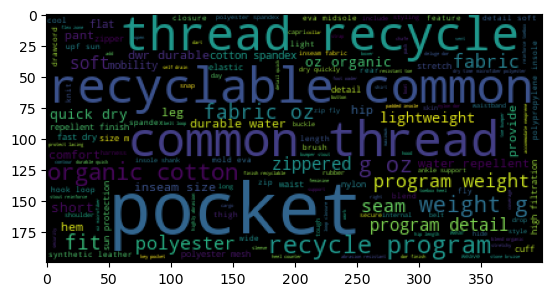

Label 0:


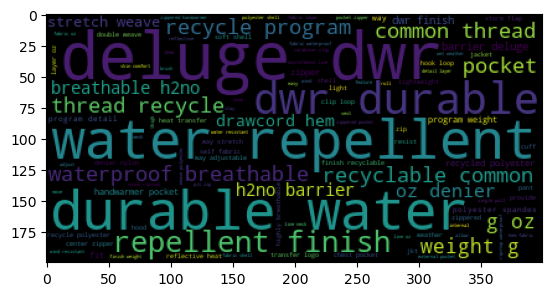

Label 1:


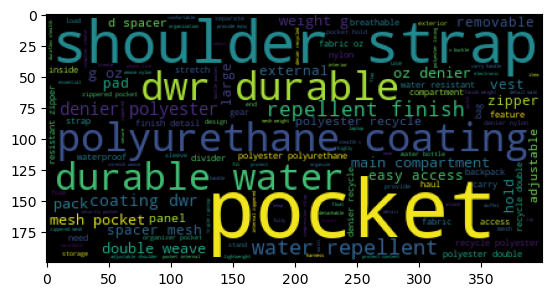

Label 2:


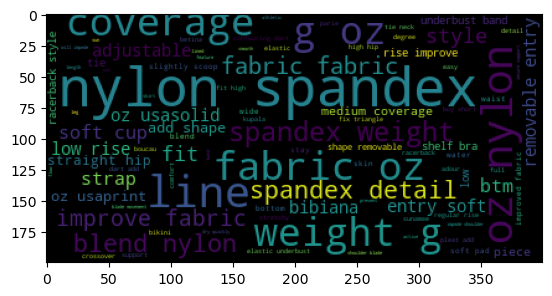

Label 3:


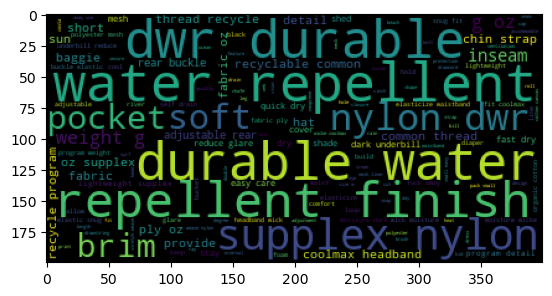

Label 4:


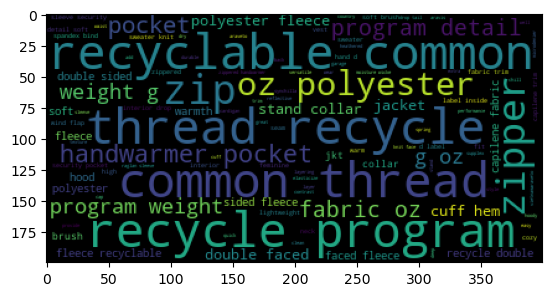

Label 5:


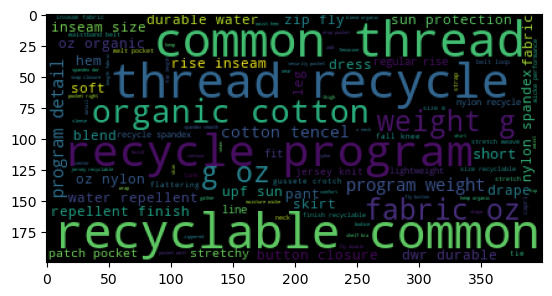

Label 6:


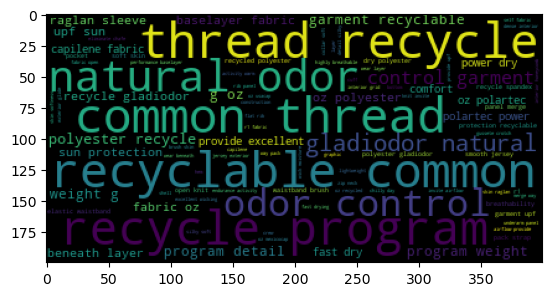

Label 7:


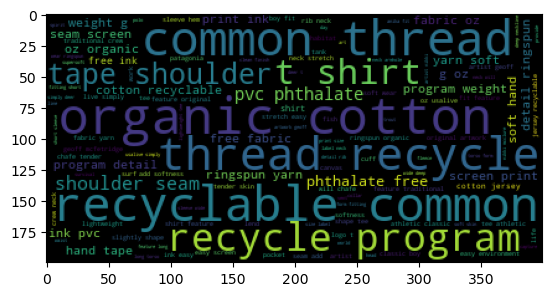

Label 8:


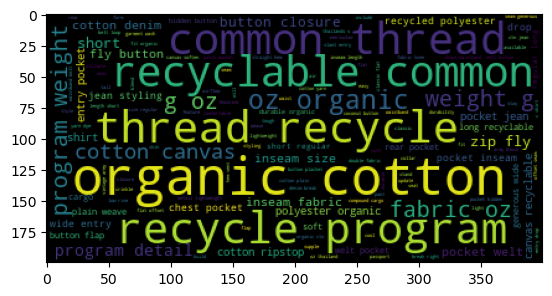

Label 9:


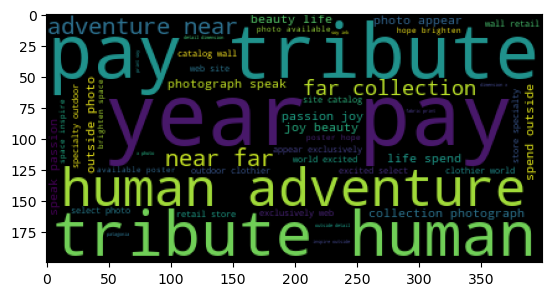

Label 10:


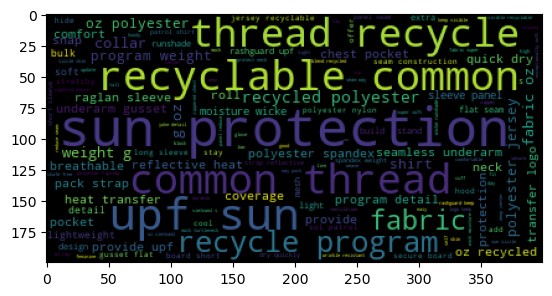

Label 11:


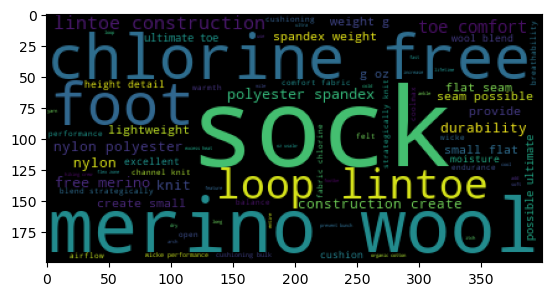

Label 12:


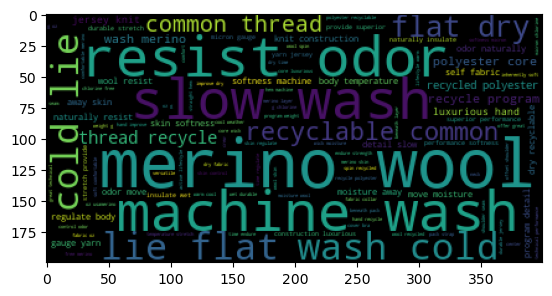

Label 13:


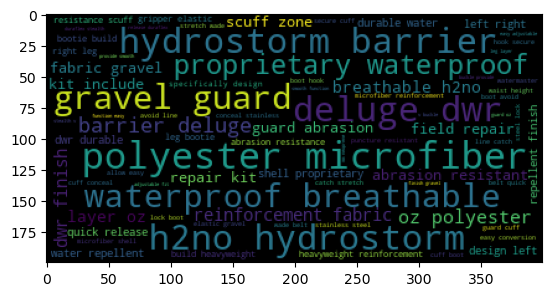

Label 14:


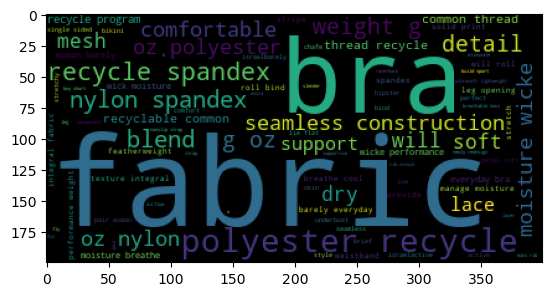

Label 15:


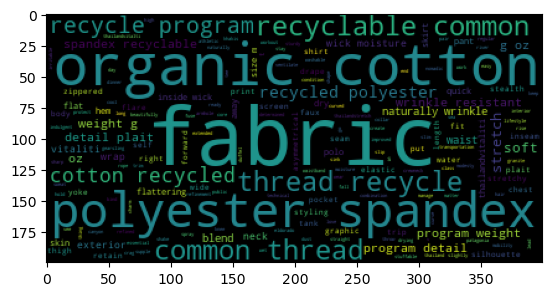

Label 16:


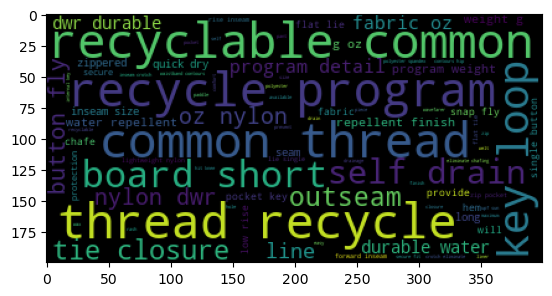

In [ ]:
for label in unique_labels:
    all_lemmas = "".join(df[labels == label]["clean_docs"].to_list())
    wd = wordcloud.WordCloud()
    cloud = wd.generate(all_lemmas)
    print(f"Label {label}:")
    plt.imshow(cloud)
    plt.show()

In [ ]:
# This one has very few outliers and the labels are a lot more balanced than many others I've obtained.
# However, it has 23 labels, which is more than the maximum given in the project instructions, and it has a few labels that only occur twice,
# which doesn't allow me to provide the user with 5 other suggestions, as described in the project instructions.

"""
eps: 0.7016
min_samples: 2
Outliers: 6
Labels spread:[46, 32, 191, 32, 2, 24, 20, 16, 61, 2, 3, 8, 3, 2, 9, 15, 4, 2, 5, 5, 2, 7, 3]
PCA components: 500
Minimum feature occurrence in the TF-IDF matrix: 5
"""

db = DBSCAN(eps=0.7016, min_samples=2, metric="cosine", algorithm="brute")
db.fit(_500_for_dbscan_PC)
labels = db.labels_
unique_labels = np.unique(labels)
print([len(_500_for_dbscan_PC[labels == label]) for label in unique_labels])

[6, 46, 32, 191, 32, 2, 24, 20, 16, 61, 2, 3, 8, 3, 2, 9, 15, 4, 2, 5, 5, 2, 7, 3]


In [ ]:
few_outliers_df = data_df.copy()
few_outliers_df["labels"] = labels
few_outliers_df.to_csv("Data/few_outliers_data.csv")

Label -1:


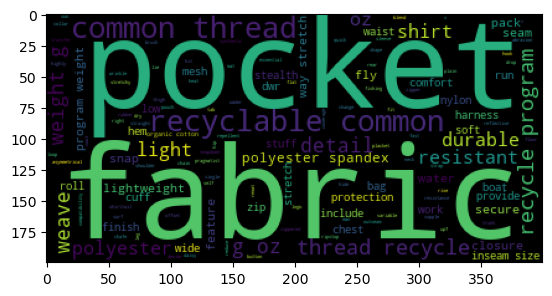

Label 0:


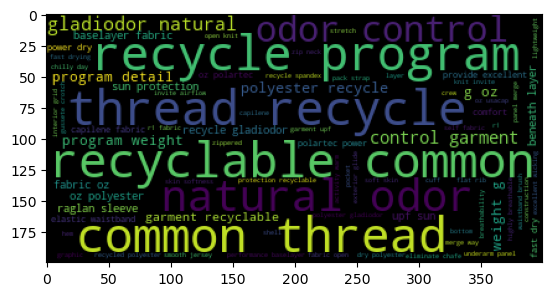

Label 1:


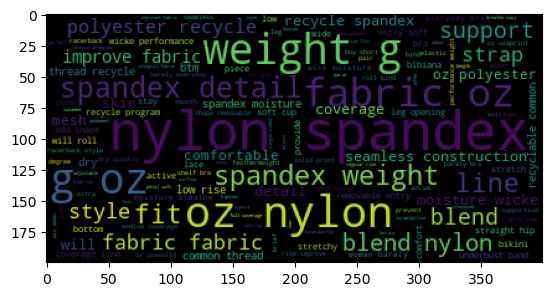

Label 2:


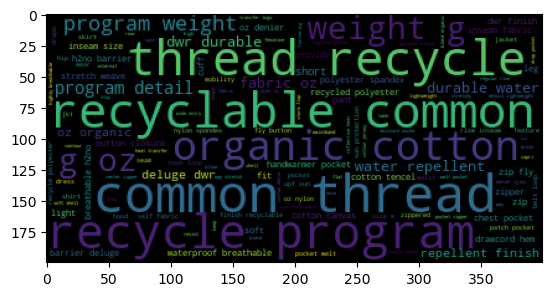

Label 3:


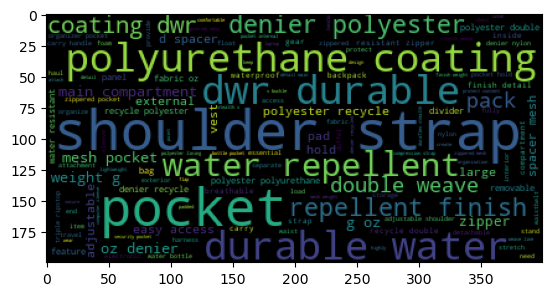

Label 4:


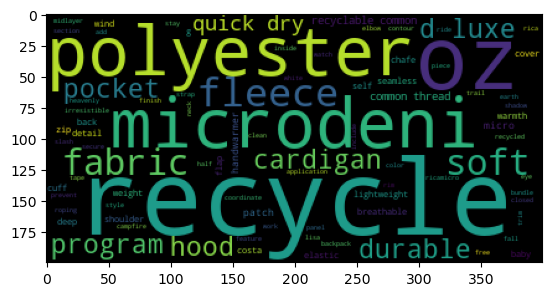

Label 5:


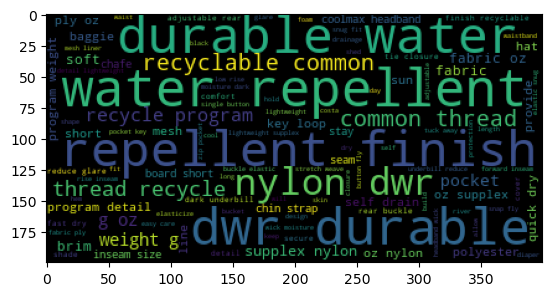

Label 6:


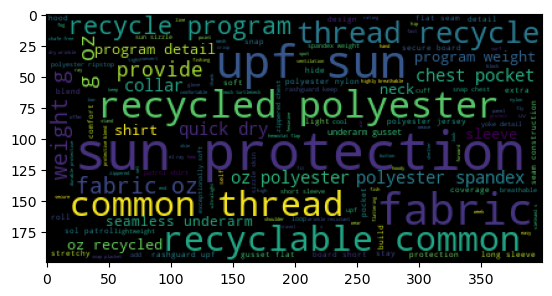

Label 7:


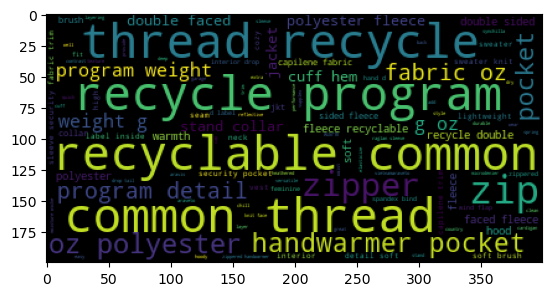

Label 8:


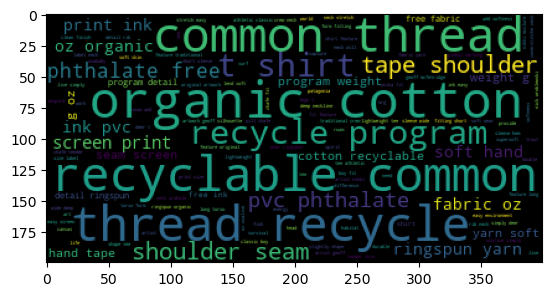

Label 9:


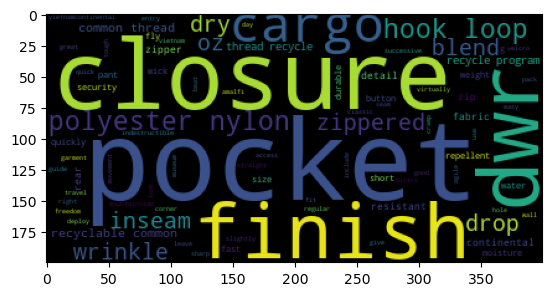

Label 10:


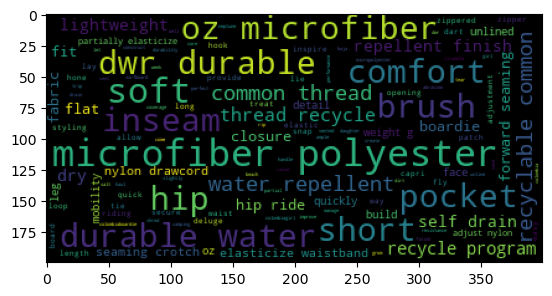

Label 11:


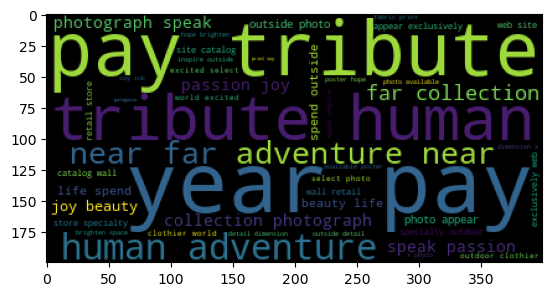

Label 12:


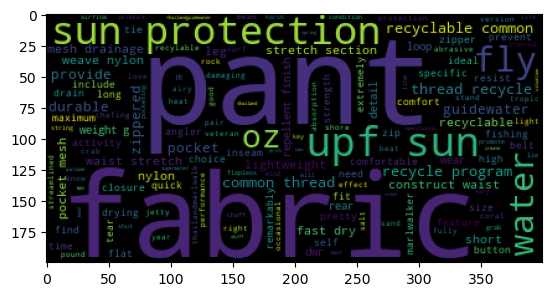

Label 13:


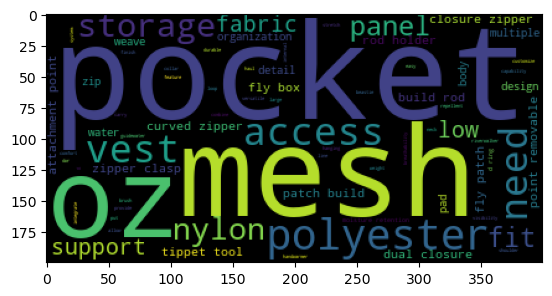

Label 14:


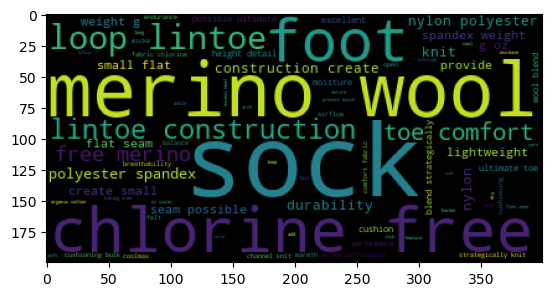

Label 15:


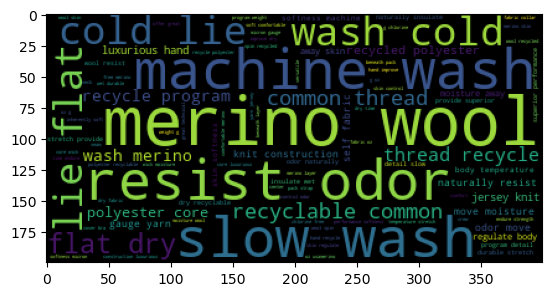

Label 16:


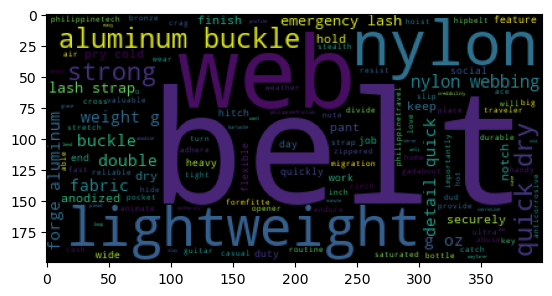

Label 17:


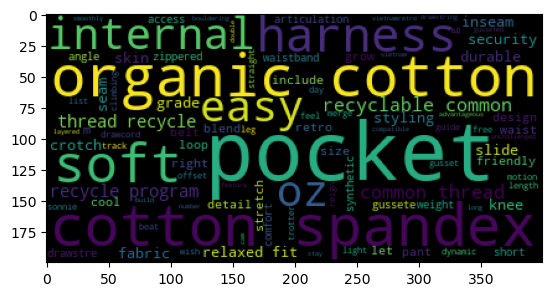

Label 18:


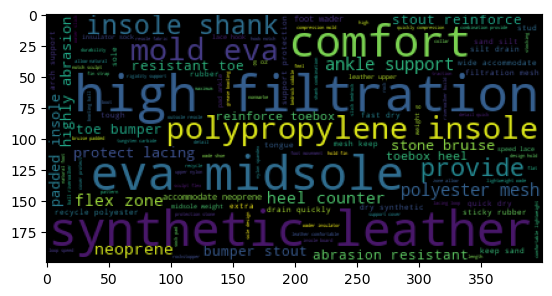

Label 19:


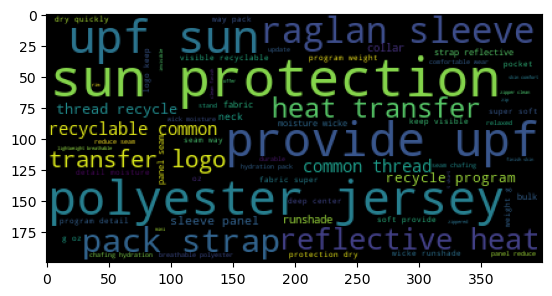

Label 20:


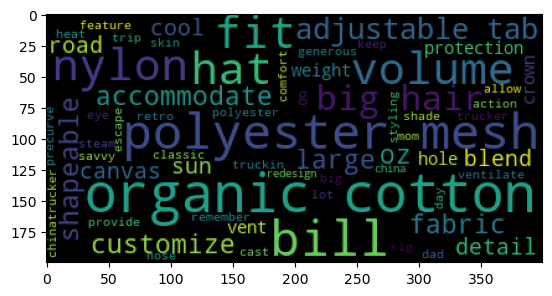

Label 21:


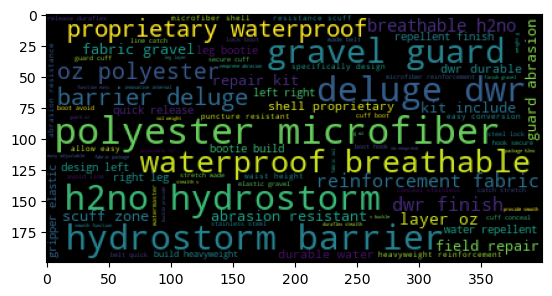

Label 22:


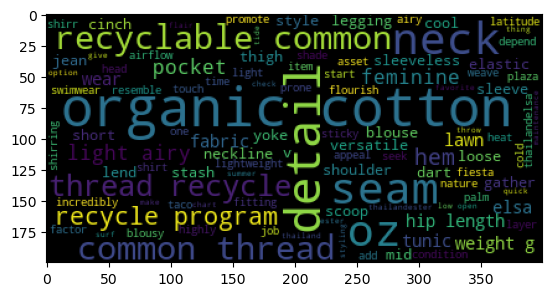

In [ ]:
for label in unique_labels:
    all_lemmas = "".join(df[labels == label]["clean_docs"].to_list())
    wd = wordcloud.WordCloud()
    cloud = wd.generate(all_lemmas)
    print(f"Label {label}:")
    plt.imshow(cloud)
    plt.show()